In [1]:
%%capture cap --no-stderr
!pip install top2vec
!pip install 'top2vec[sentence_encoders]'
!pip install 'top2vec[sentence_transformers]'
!pip install 'top2vec[indexing]'
!pip install tensorflow tensorflow_hub tensorflow_text

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import multiprocessing
import sys
import warnings
from ast import literal_eval

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (ExtraTreesClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix, f1_score,
                             make_scorer, precision_score, recall_score,
                             roc_auc_score)
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from top2vec import Top2Vec

warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

%matplotlib inline

In [4]:
data = pd.read_csv('/content/gdrive/My Drive/ESG/parsed_data.csv', index_col=0)
data['text_cyr'] = data['text'].str.replace(r"[^а-яА-Я\s]+", '', regex=True).str.strip()
data['text_cyr_words'] = data['text_cyr'].str.split()
data = data.replace(r'^s*$', float('NaN'), regex=True).dropna().reset_index(drop=True)
data.loc[data['rating'] == 101, 'rating'] = '101'
data['rating'] = data['rating'].astype('str')
data

,rating,company,url,text,text_cyr,text_cyr_words
0,1,НЛМК,https://nlmk.com/ru/sustainability/,устойчивый развитие подход политика приоритет,устойчивый развитие подход политика приоритет,"[устойчивый, развитие, подход, политика, приор..."
1,1,НЛМК,https://nlmk.com/ru/sustainability/,просмотр содержимое разрешить работа кук,просмотр содержимое разрешить работа кук,"[просмотр, содержимое, разрешить, работа, кук]"
2,1,НЛМК,https://nlmk.com/ru/sustainability/,вход сотрудник,вход сотрудник,"[вход, сотрудник]"
3,1,НЛМК,https://nlmk.com/ru/sustainability/,поставщик подрядчик,поставщик подрядчик,"[поставщик, подрядчик]"
4,1,НЛМК,https://nlmk.com/ru/sustainability/,контакт,контакт,[контакт]
...,...,...,...,...,...,...
711642,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,телефон,телефон,[телефон]
711643,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,москва,москва,[москва]
711644,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,рубцов переулок далее,рубцов переулок далее,"[рубцов, переулок, далее]"
711645,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,wwwpetropavlovskplccomпубличный компания,публичный компания,"[публичный, компания]"


## Модель по данным сайтов

### Сохранение модели Top2Vec

In [ ]:
multiprocessing.cpu_count()

2

In [ ]:
%%time
docs = np.unique(data['text_cyr'].values)

model = Top2Vec(
    documents=docs,
    embedding_model='universal-sentence-encoder',
    speed='learn',
    workers=multiprocessing.cpu_count(),
    verbose=True
)

2023-05-19 17:06:46,737 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-05-19 17:07:02,592 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2023-05-19 17:07:17,867 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-05-19 17:08:16,031 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-05-19 17:13:08,746 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-05-19 17:13:41,076 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


CPU times: user 8min 34s, sys: 25.8 s, total: 9min
Wall time: 6min 59s


In [ ]:
model.get_num_topics()

612

In [ ]:
%%time
topic_mapping = model.hierarchical_topic_reduction(num_topics=60)

In [ ]:
model.save('/content/gdrive/My Drive/ESG/model_sites')

### Загрузка модели Top2Vec

In [ ]:
model = Top2Vec.load('/content/gdrive/My Drive/ESG/model_sites')

In [ ]:
print(model.get_num_topics(reduced=False))
print(model.get_num_topics(reduced=True))

612
60


### Сохранение словаря топиков

In [ ]:
topics_words, word_scores, topic_nums = model.get_topics(reduced=True)
topics_words, word_scores, topic_nums

(array([['перевод', 'нииар', 'дать', ..., 'процентныи', 'тч', 'проект'],
        ['ширина', 'весна', 'инсаидер', ..., 'развитои', 'мбир',
         'алексеи'],
        ['перевод', 'перевести', 'фактор', ..., 'будущее',
         'отрицательныи', 'период'],
        ...,
        ['ржд', 'далеебанк', 'дать', ..., 'гарантировать',
         'счетаобезличить', 'детскии'],
        ['детскии', 'начислить', 'далеебанк', ..., 'биоразнообразие',
         'транспортировка', 'европа'],
        ['перевод', 'далее', 'дать', ..., 'энергетик', 'ленинградскии',
         'номинальныи']], dtype='<U15'),
 array([[0.39534324, 0.3149311 , 0.3009233 , ..., 0.1802478 , 0.17866981,
         0.17816834],
        [0.8187947 , 0.796512  , 0.78960717, ..., 0.76534873, 0.76528883,
         0.76519775],
        [0.2998237 , 0.2295771 , 0.21583104, ..., 0.14054307, 0.1405335 ,
         0.1402581 ],
        ...,
        [0.4376955 , 0.43654794, 0.42789972, ..., 0.3141315 , 0.31402248,
         0.31372875],
        [0.479

In [ ]:
topics_raw_data = pd.DataFrame({'topic_num': topic_nums, 'topics_words': list(topics_words)})
topics_raw_data.head()

,topic_num,topics_words
0,0,"[перевод, нииар, дать, перевести, как, спасибо..."
1,1,"[ширина, весна, инсаидер, торговля, гок, бн, с..."
2,2,"[перевод, перевести, фактор, нииар, как, локал..."
3,3,"[дать, далеебанк, циркуляционныи, детскии, нул..."
4,4,"[перевод, перевести, фактор, как, кп, локализа..."


In [ ]:
topics_raw_data.to_excel('/content/gdrive/My Drive/ESG/topics_raw_data.xlsx', encoding='utf-8', index=False)

### Сбор корпусов слов по компаниям

In [ ]:
data.head()

,rating,company,url,text,text_cyr,text_cyr_words
0,1,НЛМК,https://nlmk.com/ru/sustainability/,устойчивый развитие подход политика приоритет,устойчивый развитие подход политика приоритет,"[устойчивый, развитие, подход, политика, приор..."
1,1,НЛМК,https://nlmk.com/ru/sustainability/,просмотр содержимое разрешить работа кук,просмотр содержимое разрешить работа кук,"[просмотр, содержимое, разрешить, работа, кук]"
2,1,НЛМК,https://nlmk.com/ru/sustainability/,вход сотрудник,вход сотрудник,"[вход, сотрудник]"
3,1,НЛМК,https://nlmk.com/ru/sustainability/,поставщик подрядчик,поставщик подрядчик,"[поставщик, подрядчик]"
4,1,НЛМК,https://nlmk.com/ru/sustainability/,контакт,контакт,[контакт]


In [ ]:
%%time
data_company = data.groupby(['company', 'rating'])[['text_cyr_words']].apply(sum).reset_index().sort_values(by=['company', 'rating'])
data_company['text_cyr_words'] = data_company['text_cyr_words'].agg(pd.unique)

CPU times: user 10min 52s, sys: 4.55 s, total: 10min 56s
Wall time: 11min 25s


In [ ]:
data_company

,company,rating,text_cyr_words
0,"""Каустик"" (г. Волгоград)",103,"[отчт, ао, каустик, обращение, генеральный, ди..."
1,"""Нефтиса"", нефтяная компания",150,"[устойчивый, развитие, общий, вопрос, телефон,..."
2,"""Соликамскбумпром""",99,"[компания, ао, соликамскбумпром, история, руко..."
3,"""Титан"", группа компаний (деревообработка)",156,"[устойчивый, развитие, группа, компания, титан..."
4,En+ Group,33,"[устойчивый, развитие, ен, оранж, компания, за..."
...,...,...,...
130,Транспортная группа FESCO,94,"[устойчивый, развитие, транспортный, группа, п..."
131,ЧФМК,114,"[социальный, политика, ао, чфмк, закупка, непр..."
132,Челябинский трубопрокатный завод (ЧТПЗ),101,"[заявление, ограничение, ответственность, г, о..."
133,Южуралзолото Группа Компаний,145,"[компания, наш, цель, история, руководство, ко..."


In [ ]:
data_company.to_csv('/content/gdrive/My Drive/ESG/parsed_data_company.csv', encoding='utf-8')

### Присваивание компаниям топиков

In [ ]:
topics_data = pd.read_excel('/content/gdrive/My Drive/ESG/topics_data.xlsx')
topics_data['topics_words'] = topics_data['topics_words'].apply(lambda x: literal_eval(x.replace(' ', ','))).tolist()
topics_data

,parameter,topic_name,topic_num,topics_words
0,S,Отношения с работниками,0,"[перевод, нииар, дать, перевести, как, спасибо..."
1,G,Дивиденды и акционеры,1,"[ширина, весна, инсаидер, торговля, гок, бн, с..."
2,E,Энергия,2,"[перевод, перевести, фактор, нииар, как, локал..."
3,E,Экологический менеджмент,3,"[дать, далеебанк, циркуляционныи, детскии, нул..."
4,E,Энергия,4,"[перевод, перевести, фактор, как, кп, локализа..."
5,S,Трудовые отношения,5,"[перевод, дать, далеебанк, нииар, спасибо, цир..."
6,E,Экологический менеджмент,6,"[практически, пластика, публиковать, равныи, к..."
7,S,Отношения с потребителями,7,"[дать, далеебанк, циркуляционныи, ржд, ями, де..."
8,S,Охрана здоровья,8,"[нулевои, счетаобезличить, циркуляционныи, пра..."
9,E,Энергия,9,"[далеебанк, дать, циркуляционныи, ржд, ркоподо..."


In [ ]:
topics_data['parameter'].value_counts()

S    20
G    20
E    20
Name: parameter, dtype: int64

In [ ]:
data_company = pd.read_csv('/content/gdrive/My Drive/ESG/parsed_data_company.csv', index_col=0)
data_company['text_cyr_words'] = data_company['text_cyr_words'].apply(lambda x: literal_eval(x.replace(' ', ','))).tolist()
data_company

,company,rating,text_cyr_words
0,"""Каустик"" (г. Волгоград)",103,"[отчт, ао, каустик, обращение, генеральный, ди..."
1,"""Нефтиса"", нефтяная компания",150,"[устойчивый, развитие, общий, вопрос, телефон,..."
2,"""Соликамскбумпром""",99,"[компания, ао, соликамскбумпром, история, руко..."
3,"""Титан"", группа компаний (деревообработка)",156,"[устойчивый, развитие, группа, компания, титан..."
4,En+ Group,33,"[устойчивый, развитие, ен, оранж, компания, за..."
...,...,...,...
130,Транспортная группа FESCO,94,"[устойчивый, развитие, транспортный, группа, п..."
131,ЧФМК,114,"[социальный, политика, ао, чфмк, закупка, непр..."
132,Челябинский трубопрокатный завод (ЧТПЗ),101,"[заявление, ограничение, ответственность, г, о..."
133,Южуралзолото Группа Компаний,145,"[компания, наш, цель, история, руководство, ко..."


In [ ]:
topics_companies_data = data_company.merge(topics_data, how='cross')
topics_companies_data

,company,rating,text_cyr_words,parameter,topic_name,topic_num,topics_words
0,"""Каустик"" (г. Волгоград)",103,"[отчт, ао, каустик, обращение, генеральный, ди...",S,Отношения с работниками,0,"[перевод, нииар, дать, перевести, как, спасибо..."
1,"""Каустик"" (г. Волгоград)",103,"[отчт, ао, каустик, обращение, генеральный, ди...",G,Дивиденды и акционеры,1,"[ширина, весна, инсаидер, торговля, гок, бн, с..."
2,"""Каустик"" (г. Волгоград)",103,"[отчт, ао, каустик, обращение, генеральный, ди...",E,Энергия,2,"[перевод, перевести, фактор, нииар, как, локал..."
3,"""Каустик"" (г. Волгоград)",103,"[отчт, ао, каустик, обращение, генеральный, ди...",E,Экологический менеджмент,3,"[дать, далеебанк, циркуляционныи, детскии, нул..."
4,"""Каустик"" (г. Волгоград)",103,"[отчт, ао, каустик, обращение, генеральный, ди...",E,Энергия,4,"[перевод, перевести, фактор, как, кп, локализа..."
...,...,...,...,...,...,...,...
8095,Юникредит Банк,73,"[группа, объявлять, новый, цель, сфера, защита...",G,Инновации,55,"[далеебанк, нулевои, ями, строи, заполнить, де..."
8096,Юникредит Банк,73,"[группа, объявлять, новый, цель, сфера, защита...",G,Эффективность и производительность,56,"[дать, перевод, далеебанк, ржд, циркуляционныи..."
8097,Юникредит Банк,73,"[группа, объявлять, новый, цель, сфера, защита...",E,Отходы,57,"[ржд, далеебанк, дать, циркуляционныи, ями, ну..."
8098,Юникредит Банк,73,"[группа, объявлять, новый, цель, сфера, защита...",G,Отчетность и прозрачность,58,"[детскии, начислить, далеебанк, дать, частота,..."


In [ ]:
%%time
cosine_similarities = []
for index, row in topics_companies_data.iterrows():
    tf_idf = TfidfVectorizer()

    text_cyr_words = np.array([elm for elm in row['text_cyr_words'] if isinstance(elm, str)])
    topics_words = np.array([elm for elm in row['topics_words'] if isinstance(elm, str)])

    text_cyr_words = [' '.join(text_cyr_words)]
    topics_words = [' '.join(topics_words)]

    data_company_tf = tf_idf.fit_transform(text_cyr_words)
    topics_data_tf = tf_idf.transform(topics_words)

    cosine_similarity = linear_kernel(data_company_tf, topics_data_tf).flatten()
    cosine_similarities.append(cosine_similarity[0])

CPU times: user 1min 50s, sys: 397 ms, total: 1min 50s
Wall time: 2min


In [ ]:
topics_companies_data['cosine_similarity'] = cosine_similarities
topics_companies_data.head()

,company,rating,text_cyr_words,parameter,topic_name,topic_num,topics_words,cosine_similarity
0,"""Каустик"" (г. Волгоград)",103,"[отчт, ао, каустик, обращение, генеральный, ди...",S,Отношения с работниками,0,"[перевод, нииар, дать, перевести, как, спасибо...",0.072684
1,"""Каустик"" (г. Волгоград)",103,"[отчт, ао, каустик, обращение, генеральный, ди...",G,Дивиденды и акционеры,1,"[ширина, весна, инсаидер, торговля, гок, бн, с...",0.075235
2,"""Каустик"" (г. Волгоград)",103,"[отчт, ао, каустик, обращение, генеральный, ди...",E,Энергия,2,"[перевод, перевести, фактор, нииар, как, локал...",0.070040
3,"""Каустик"" (г. Волгоград)",103,"[отчт, ао, каустик, обращение, генеральный, ди...",E,Экологический менеджмент,3,"[дать, далеебанк, циркуляционныи, детскии, нул...",0.058277
4,"""Каустик"" (г. Волгоград)",103,"[отчт, ао, каустик, обращение, генеральный, ди...",E,Энергия,4,"[перевод, перевести, фактор, как, кп, локализа...",0.070040


In [ ]:
features_data = (
    topics_companies_data
    .pivot(index=['company', 'rating'], columns='topic_num', values='cosine_similarity')
    .reset_index()
    .add_prefix('topic_num_')
    .rename(columns={'topic_num_company': 'company', 'topic_num_rating': 'ESG_Rank'})
)

features_data.head()

topic_num,company,ESG_Rank,topic_num_0,topic_num_1,topic_num_2,topic_num_3,topic_num_4,topic_num_5,topic_num_6,topic_num_7,...,topic_num_50,topic_num_51,topic_num_52,topic_num_53,topic_num_54,topic_num_55,topic_num_56,topic_num_57,topic_num_58,topic_num_59
0,"""Каустик"" (г. Волгоград)",103,0.072684,0.075235,0.070040,0.058277,0.070040,0.070040,0.067293,0.072684,...,0.067293,0.086874,0.064428,0.072684,0.067293,0.064428,0.070040,0.072684,0.064428,0.067293
1,"""Нефтиса"", нефтяная компания",150,0.100031,0.066164,0.093571,0.061256,0.093571,0.093571,0.055919,0.079082,...,0.093571,0.100031,0.066164,0.075023,0.082942,0.082942,0.082942,0.075023,0.079082,0.090167
2,"""Соликамскбумпром""",99,0.070157,0.073022,0.092810,0.060758,0.092810,0.070157,0.057283,0.060758,...,0.067171,0.092810,0.073022,0.070157,0.064045,0.081011,0.064045,0.064045,0.067171,0.070157
3,"""Титан"", группа компаний (деревообработка)",156,0.127205,0.056888,0.139347,0.000000,0.139347,0.098533,0.000000,0.000000,...,0.080452,0.127205,0.056888,0.056888,0.056888,0.056888,0.056888,0.000000,0.000000,0.056888
4,En+ Group,33,0.077469,0.069830,0.092882,0.058102,0.090841,0.077469,0.072466,0.061245,...,0.069830,0.100636,0.069830,0.075009,0.067090,0.069830,0.067090,0.069830,0.064234,0.072466


In [ ]:
raex_list = (
    pd.read_excel("/content/gdrive/My Drive/ESG/RAEX list.xlsx")
    .dropna(subset=["url_sustainability"])
    .reset_index(drop=True)
    .drop(columns=['№', 'Код MOEX', 'Подотрасль', 'Год последней оцененной отчетности', 'url', 'url_sustainability'])
    .rename(columns={
        'Название': 'company',
        'ESG-рейтинг': 'ESG_Rating_band',
        'E Rank': 'E_Rank',
        'E-рейтинг': 'E_Rating_band',
        'S Rank': 'S_Rank',
        'S-рейтинг': 'S_Rating_band',
        'G Rank': 'G_Rank',
        'G-рейтинг': 'G_Rating_band',
    })
)

raex_list['E_Rank'] = raex_list['E_Rank'].astype('str')
raex_list['S_Rank'] = raex_list['S_Rank'].astype('str')
raex_list['G_Rank'] = raex_list['G_Rank'].astype('str')

raex_list.head()

,company,ESG_Rating_band,E_Rank,E_Rating_band,S_Rank,S_Rating_band,G_Rank,G_Rating_band
0,НЛМК,AA,2,AA,2,AA,21,A
1,«Полюс»,AA,1,AAA,14,A,27,A
2,«Уралкалий»,A,6,BBB,1,AA,6,AA
3,«ЭЛ5-Энерго»,A,9,BBB,9,A,2,AAA
4,«Полиметалл»,A,4,A,5,A,12,AA


In [ ]:
features_data = features_data.merge(raex_list, on='company', how='left')
features_data

,company,ESG_Rank,topic_num_0,topic_num_1,topic_num_2,topic_num_3,topic_num_4,topic_num_5,topic_num_6,topic_num_7,...,topic_num_57,topic_num_58,topic_num_59,ESG_Rating_band,E_Rank,E_Rating_band,S_Rank,S_Rating_band,G_Rank,G_Rating_band
0,"""Каустик"" (г. Волгоград)",103,0.072684,0.075235,0.070040,0.058277,0.070040,0.070040,0.067293,0.072684,...,0.072684,0.064428,0.067293,CCC,118,C,90,CCC,88,BB
1,"""Нефтиса"", нефтяная компания",150,0.100031,0.066164,0.093571,0.061256,0.093571,0.093571,0.055919,0.079082,...,0.075023,0.079082,0.090167,C,145,C,146,CC,144,CC
2,"""Соликамскбумпром""",99,0.070157,0.073022,0.092810,0.060758,0.092810,0.070157,0.057283,0.060758,...,0.064045,0.067171,0.070157,CCC,85,CC,108,CCC,96,BB
3,"""Титан"", группа компаний (деревообработка)",156,0.127205,0.056888,0.139347,0.000000,0.139347,0.098533,0.000000,0.000000,...,0.000000,0.000000,0.056888,C,148,C,152,C,152-154,CC
4,En+ Group,33,0.077469,0.069830,0.092882,0.058102,0.090841,0.077469,0.072466,0.061245,...,0.069830,0.064234,0.072466,BB,29,B,45,BB,32,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,Транспортная группа FESCO,94,0.069566,0.062925,0.074158,0.055494,0.072659,0.069566,0.057442,0.059326,...,0.066329,0.067967,0.061152,B,127,C,105,CCC,60,BBB
131,ЧФМК,114,0.078811,0.078811,0.091003,0.045502,0.101745,0.064349,0.078811,0.064349,...,0.064349,0.064349,0.045502,CCC,121,C,89,CCC,113,B
132,Челябинский трубопрокатный завод (ЧТПЗ),101,0.062891,0.071545,0.073153,0.048236,0.073153,0.064715,0.057073,0.057073,...,0.066488,0.061014,0.059076,CCC,115,C,66,B,105,BB
133,Южуралзолото Группа Компаний,145,0.078386,0.087638,0.099923,0.048002,0.087638,0.061970,0.048002,0.048002,...,0.067884,0.061970,0.061970,CC,135,C,143,CC,143,CC


In [ ]:
features_data.to_csv('/content/gdrive/My Drive/ESG/features_data.csv', encoding='utf-8')

## Модель по данным отчетов

In [ ]:
model = Top2Vec.load('/content/gdrive/My Drive/ESG/model_pages_2.uu')
model.get_num_topics()

325

In [ ]:
topic_words = model.topic_words.reshape(-1)
topic_words

array(['работник', 'персонал', 'сотрудник', ..., 'постепенныи',
       'непубличныи', 'отличительныи'], dtype='<U15')

In [ ]:
data['text_cyr_words_insect'] = data['text_cyr_words'].map(lambda x: np.intersect1d(x, topic_words))
data.head()

,rating,company,url,text,text_cyr,text_cyr_words,text_cyr_words_insect
0,1,НЛМК,https://nlmk.com/ru/sustainability/,устойчивый развитие подход политика приоритет,устойчивый развитие подход политика приоритет,"[устойчивый, развитие, подход, политика, приор...","[подход, политика, приоритет]"
1,1,НЛМК,https://nlmk.com/ru/sustainability/,просмотр содержимое разрешить работа кук,просмотр содержимое разрешить работа кук,"[просмотр, содержимое, разрешить, работа, кук]",[]
2,1,НЛМК,https://nlmk.com/ru/sustainability/,вход сотрудник,вход сотрудник,"[вход, сотрудник]",[сотрудник]
3,1,НЛМК,https://nlmk.com/ru/sustainability/,поставщик подрядчик,поставщик подрядчик,"[поставщик, подрядчик]",[подрядчик]
4,1,НЛМК,https://nlmk.com/ru/sustainability/,контакт,контакт,[контакт],[контакт]


In [ ]:
data.to_csv('/content/gdrive/My Drive/ESG/parsed_data_top2vec_model_insect.csv', encoding='utf-8')

In [ ]:
data_top2vec_model_insect = pd.read_csv('/content/gdrive/My Drive/ESG/parsed_data_top2vec_model_insect.csv', index_col=0)
data_top2vec_model_insect['text_cyr_words_insect'] = data_top2vec_model_insect['text_cyr_words_insect'].apply(lambda x: literal_eval(x.replace(' ', ','))).tolist()
data_top2vec_model_insect = data_top2vec_model_insect[~data_top2vec_model_insect['text_cyr_words_insect'].map(lambda x: set(x).issubset(['[]']))].reset_index(drop=True)
data_top2vec_model_insect

,rating,company,url,text,text_cyr,text_cyr_words,text_cyr_words_insect
0,1,НЛМК,https://nlmk.com/ru/sustainability/,устойчивый развитие подход политика приоритет,устойчивый развитие подход политика приоритет,"['устойчивый', 'развитие', 'подход', 'политика...","[подход, политика, приоритет]"
1,1,НЛМК,https://nlmk.com/ru/sustainability/,вход сотрудник,вход сотрудник,"['вход', 'сотрудник']",[сотрудник]
2,1,НЛМК,https://nlmk.com/ru/sustainability/,поставщик подрядчик,поставщик подрядчик,"['поставщик', 'подрядчик']",[подрядчик]
3,1,НЛМК,https://nlmk.com/ru/sustainability/,контакт,контакт,['контакт'],[контакт]
4,1,НЛМК,https://nlmk.com/ru/sustainability/,нлмк россия,нлмк россия,"['нлмк', 'россия']",[россия]
...,...,...,...,...,...,...,...
512266,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,удельный выброс парниковый газовт coэква так,удельный выброс парниковый газовт эква так,"['удельный', 'выброс', 'парниковый', 'газовт',...","[выброс, так]"
512267,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,так coэквт переработать концентрат,так эквт переработать концентрат,"['так', 'эквт', 'переработать', 'концентрат']","[концентрат, так]"
512268,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,телефон,телефон,['телефон'],[телефон]
512269,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,москва,москва,['москва'],[москва]


In [ ]:
data_top2vec_model_insect['topic_nums'] = data_top2vec_model_insect['text_cyr_words_insect'].apply(
    lambda x: model.search_topics(keywords=x, num_topics=3)[3]
)
data_top2vec_model_insect

,rating,company,url,text,text_cyr,text_cyr_words,text_cyr_words_insect,topic_nums
0,1,НЛМК,https://nlmk.com/ru/sustainability/,устойчивый развитие подход политика приоритет,устойчивый развитие подход политика приоритет,"['устойчивый', 'развитие', 'подход', 'политика...","[подход, политика, приоритет]","[133, 144, 172]"
1,1,НЛМК,https://nlmk.com/ru/sustainability/,вход сотрудник,вход сотрудник,"['вход', 'сотрудник']",[сотрудник],"[172, 133, 198]"
2,1,НЛМК,https://nlmk.com/ru/sustainability/,поставщик подрядчик,поставщик подрядчик,"['поставщик', 'подрядчик']",[подрядчик],"[172, 323, 133]"
3,1,НЛМК,https://nlmk.com/ru/sustainability/,контакт,контакт,['контакт'],[контакт],"[133, 296, 171]"
4,1,НЛМК,https://nlmk.com/ru/sustainability/,нлмк россия,нлмк россия,"['нлмк', 'россия']",[россия],"[133, 172, 321]"
...,...,...,...,...,...,...,...,...
512266,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,удельный выброс парниковый газовт coэква так,удельный выброс парниковый газовт эква так,"['удельный', 'выброс', 'парниковый', 'газовт',...","[выброс, так]","[198, 133, 319]"
512267,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,так coэквт переработать концентрат,так эквт переработать концентрат,"['так', 'эквт', 'переработать', 'концентрат']","[концентрат, так]","[198, 319, 313]"
512268,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,телефон,телефон,['телефон'],[телефон],"[133, 171, 198]"
512269,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,москва,москва,['москва'],[москва],"[133, 172, 321]"


In [ ]:
data_top2vec_model_insect['rating'] = data_top2vec_model_insect['rating'].astype('object').apply(str)
data_top2vec_model_insect['company'] = data_top2vec_model_insect['company'].astype('object').apply(str)
data_top2vec_model_insect

,rating,company,url,text,text_cyr,text_cyr_words,text_cyr_words_insect,topic_nums
0,1,НЛМК,https://nlmk.com/ru/sustainability/,устойчивый развитие подход политика приоритет,устойчивый развитие подход политика приоритет,"['устойчивый', 'развитие', 'подход', 'политика...","[подход, политика, приоритет]","[133, 144, 172]"
1,1,НЛМК,https://nlmk.com/ru/sustainability/,вход сотрудник,вход сотрудник,"['вход', 'сотрудник']",[сотрудник],"[172, 133, 198]"
2,1,НЛМК,https://nlmk.com/ru/sustainability/,поставщик подрядчик,поставщик подрядчик,"['поставщик', 'подрядчик']",[подрядчик],"[172, 323, 133]"
3,1,НЛМК,https://nlmk.com/ru/sustainability/,контакт,контакт,['контакт'],[контакт],"[133, 296, 171]"
4,1,НЛМК,https://nlmk.com/ru/sustainability/,нлмк россия,нлмк россия,"['нлмк', 'россия']",[россия],"[133, 172, 321]"
...,...,...,...,...,...,...,...,...
512266,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,удельный выброс парниковый газовт coэква так,удельный выброс парниковый газовт эква так,"['удельный', 'выброс', 'парниковый', 'газовт',...","[выброс, так]","[198, 133, 319]"
512267,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,так coэквт переработать концентрат,так эквт переработать концентрат,"['так', 'эквт', 'переработать', 'концентрат']","[концентрат, так]","[198, 319, 313]"
512268,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,телефон,телефон,['телефон'],[телефон],"[133, 171, 198]"
512269,158-160,"«Петропавловск», группа компаний",POG-SR2020_RUS_080921.pdf,москва,москва,['москва'],[москва],"[133, 172, 321]"


In [ ]:
print(data_top2vec_model_insect['rating'].unique())

order = pd.DataFrame(data_top2vec_model_insect['rating'].unique(), columns=['rating']).reset_index()
order['index'] = order['index'] + 1
order

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '14' '15' '16' '17'
 '18' '19' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31' '32'
 '33' '34' '35' '36' '37' '38' '39' '41' '42' '43' '44' '45' '46' '47'
 '48' '49' '50' '51' '52' '54' '55' '56' '57' '58' '59' '60' '62' '63'
 '64' '65' '66' '67' '71' '72' '73' '74' '75' '76' '77' '78' '79' '80'
 '81' '83' '84' '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '96'
 '97' '99' '100' '101' '102' '103' '104' '105' '106' '107' '109' '110'
 '111' '113' '114' '115' '116' '117' '118' '119' '123' '125' '126' '127'
 '128' '129' '130' '131' '132' '134' '135' '136' '138' '141' '142' '144'
 '145' '146' '147' '148' '150' '151' '152' '153' '155' '156' '157'
 '158-160']


,index,rating
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5
...,...,...
129,130,153
130,131,155
131,132,156
132,133,157


In [ ]:
company_topics = (
    data_top2vec_model_insect
    .merge(order, on='rating', how='left')
    .groupby([
        'index',
        'rating',
        'company'
    ])['topic_nums'].apply(np.hstack)
    .to_frame()
    .reset_index()
    .set_index('index')
)
company_topics['topic_nums'] = company_topics['topic_nums'].apply(lambda x: np.unique(x))
company_topics

,rating,company,topic_nums
index,,,
1,1,НЛМК,"[77, 103, 111, 118, 133, 144, 153, 165, 166, 1..."
2,2,«Полюс»,"[103, 111, 133, 144, 153, 165, 166, 168, 171, ..."
3,3,«Уралкалий»,"[17, 77, 93, 103, 111, 118, 133, 144, 153, 165..."
4,4,«ЭЛ5-Энерго»,"[17, 93, 95, 103, 111, 133, 144, 153, 165, 166..."
5,5,«Полиметалл»,"[11, 17, 93, 95, 103, 111, 118, 129, 133, 144,..."
...,...,...,...
130,153,Кордиант,"[103, 111, 133, 144, 164, 171, 172, 175, 178, ..."
131,155,«Промышленно-металлургический холдинг» (ПМХ),"[103, 111, 129, 133, 144, 168, 171, 172, 175, ..."
132,156,"""Титан"", группа компаний (деревообработка)","[103, 111, 133, 144, 171, 172, 175, 182, 198, ..."


## Модели для предсказания рейтинга ESG

In [73]:
features_data = pd.read_csv('/content/gdrive/My Drive/ESG/features_data.csv', index_col=0)

features_data['ESG_Rank'] = np.where(features_data['ESG_Rank'] == '158-160', '158', features_data['ESG_Rank'])
features_data['E_Rank'] = np.where(features_data['E_Rank'] == '158-160', '158', features_data['E_Rank'])
features_data['S_Rank'] = np.where(features_data['S_Rank'] == '158-160', '158', features_data['S_Rank'])
features_data['G_Rank'] = np.where(features_data['G_Rank'] == '152-154', '152', features_data['G_Rank'])
features_data['G_Rank'] = np.where(features_data['G_Rank'] == '157-160', '157', features_data['G_Rank'])

features_data['ESG_Rating_band'] = np.where(features_data['ESG_Rating_band'] == 'M', 'CCC', features_data['ESG_Rating_band'])
features_data['E_Rating_band'] = np.where(features_data['E_Rating_band'] == 'AAA', 'AA', features_data['ESG_Rating_band'])

features_data['ESG_Rank'] = features_data['ESG_Rank'].astype(int)
features_data['E_Rank'] = features_data['E_Rank'].astype(int)
features_data['S_Rank'] = features_data['S_Rank'].astype(int)
features_data['G_Rank'] = features_data['G_Rank'].astype(int)

features_data['ESG_Rating_band'] = np.where(features_data['ESG_Rating_band'].isin(['AAA', 'AA', 'A']), 'A', features_data['ESG_Rating_band'])
features_data['ESG_Rating_band'] = np.where(features_data['ESG_Rating_band'].isin(['BBB', 'BB', 'B']), 'B', features_data['ESG_Rating_band'])
features_data['ESG_Rating_band'] = np.where(features_data['ESG_Rating_band'].isin(['CCC', 'CC', 'C']), 'C', features_data['ESG_Rating_band'])

features_data['E_Rating_band'] = np.where(features_data['E_Rating_band'].isin(['AAA', 'AA', 'A']), 'A', features_data['E_Rating_band'])
features_data['E_Rating_band'] = np.where(features_data['E_Rating_band'].isin(['BBB', 'BB', 'B']), 'B', features_data['E_Rating_band'])
features_data['E_Rating_band'] = np.where(features_data['E_Rating_band'].isin(['CCC', 'CC', 'C']), 'C', features_data['E_Rating_band'])

features_data['S_Rating_band'] = np.where(features_data['S_Rating_band'].isin(['AAA', 'AA', 'A']), 'A', features_data['S_Rating_band'])
features_data['S_Rating_band'] = np.where(features_data['S_Rating_band'].isin(['BBB', 'BB', 'B']), 'B', features_data['S_Rating_band'])
features_data['S_Rating_band'] = np.where(features_data['S_Rating_band'].isin(['CCC', 'CC', 'C']), 'C', features_data['S_Rating_band'])

features_data['G_Rating_band'] = np.where(features_data['G_Rating_band'].isin(['AAA', 'AA', 'A']), 'A', features_data['G_Rating_band'])
features_data['G_Rating_band'] = np.where(features_data['G_Rating_band'].isin(['BBB', 'BB', 'B']), 'B', features_data['G_Rating_band'])
features_data['G_Rating_band'] = np.where(features_data['G_Rating_band'].isin(['CCC', 'CC', 'C']), 'C', features_data['G_Rating_band'])

features_data

,company,ESG_Rank,topic_num_0,topic_num_1,topic_num_2,topic_num_3,topic_num_4,topic_num_5,topic_num_6,topic_num_7,...,topic_num_57,topic_num_58,topic_num_59,ESG_Rating_band,E_Rank,E_Rating_band,S_Rank,S_Rating_band,G_Rank,G_Rating_band
0,"""Каустик"" (г. Волгоград)",103,0.072684,0.075235,0.070040,0.058277,0.070040,0.070040,0.067293,0.072684,...,0.072684,0.064428,0.067293,C,118,C,90,C,88,B
1,"""Нефтиса"", нефтяная компания",150,0.100031,0.066164,0.093571,0.061256,0.093571,0.093571,0.055919,0.079082,...,0.075023,0.079082,0.090167,C,145,C,146,C,144,C
2,"""Соликамскбумпром""",99,0.070157,0.073022,0.092810,0.060758,0.092810,0.070157,0.057283,0.060758,...,0.064045,0.067171,0.070157,C,85,C,108,C,96,B
3,"""Титан"", группа компаний (деревообработка)",156,0.127205,0.056888,0.139347,0.000000,0.139347,0.098533,0.000000,0.000000,...,0.000000,0.000000,0.056888,C,148,C,152,C,152,C
4,En+ Group,33,0.077469,0.069830,0.092882,0.058102,0.090841,0.077469,0.072466,0.061245,...,0.069830,0.064234,0.072466,B,29,B,45,B,32,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,Транспортная группа FESCO,94,0.069566,0.062925,0.074158,0.055494,0.072659,0.069566,0.057442,0.059326,...,0.066329,0.067967,0.061152,B,127,B,105,C,60,B
131,ЧФМК,114,0.078811,0.078811,0.091003,0.045502,0.101745,0.064349,0.078811,0.064349,...,0.064349,0.064349,0.045502,C,121,C,89,C,113,B
132,Челябинский трубопрокатный завод (ЧТПЗ),101,0.062891,0.071545,0.073153,0.048236,0.073153,0.064715,0.057073,0.057073,...,0.066488,0.061014,0.059076,C,115,C,66,B,105,B
133,Южуралзолото Группа Компаний,145,0.078386,0.087638,0.099923,0.048002,0.087638,0.061970,0.048002,0.048002,...,0.067884,0.061970,0.061970,C,135,C,143,C,143,C


### Эксперимент №1: Вычисление ESG Rating band

In [ ]:
target = 'ESG_Rating_band'

X = features_data.drop(columns=['ESG_Rank', 'ESG_Rating_band', 'E_Rank', 'E_Rating_band', 'S_Rank', 'S_Rating_band', 'G_Rank', 'G_Rating_band', 'company'])
y = features_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=54, shuffle=True, stratify=y)

y.value_counts()

B    70
C    50
A    15
Name: ESG_Rating_band, dtype: int64

#### Gaussian Naive Bayes

In [ ]:
%%time
model_name = 'GaussianNaiveBayes'

param_grid = {}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', GaussianNB())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 70.3 ms, sys: 44.7 ms, total: 115 ms
Wall time: 1.8 s


{}

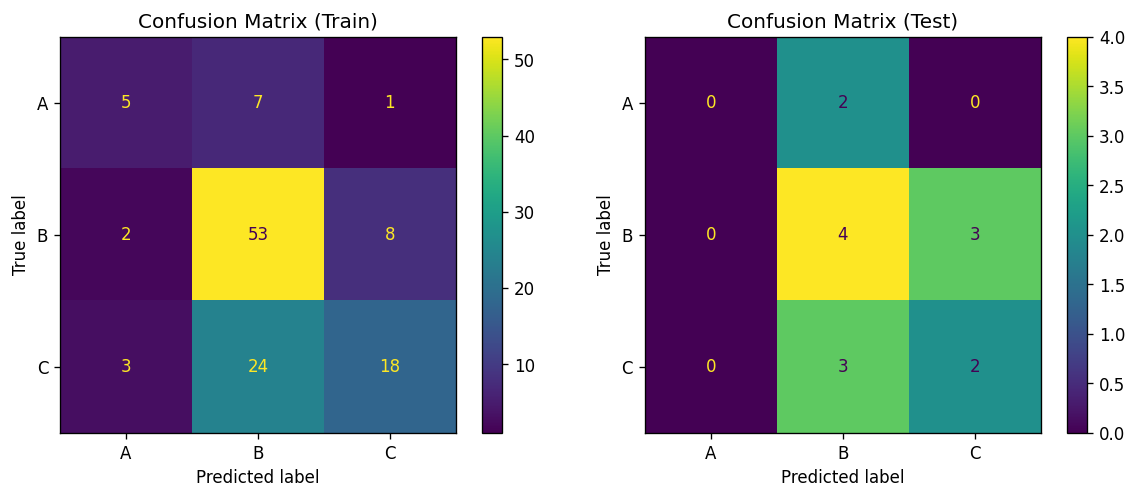

Train:
               precision    recall  f1-score   support

           A       0.50      0.38      0.43        13
           B       0.63      0.84      0.72        63
           C       0.67      0.40      0.50        45

    accuracy                           0.63       121
   macro avg       0.60      0.54      0.55       121
weighted avg       0.63      0.63      0.61       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.44      0.57      0.50         7
           C       0.40      0.40      0.40         5

    accuracy                           0.43        14
   macro avg       0.28      0.32      0.30        14
weighted avg       0.37      0.43      0.39        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GaussianNaiveBayes,Train,0.66807,0.62810,0.63017,0.62810,0.60811
1,GaussianNaiveBayes,Test,0.50340,0.42857,0.36508,0.42857,0.39286


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### K-Nearest Neighbors

In [ ]:
%%time
model_name = 'KNeighborsClassifier'

param_grid = {
    'classifier__n_neighbors': [5, 10, 20, 50, 100],
    'classifier__weights': ['uniform', 'distance'],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', KNeighborsClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 164 ms, sys: 11.8 ms, total: 176 ms
Wall time: 737 ms


{'classifier__n_neighbors': 10, 'classifier__weights': 'distance'}

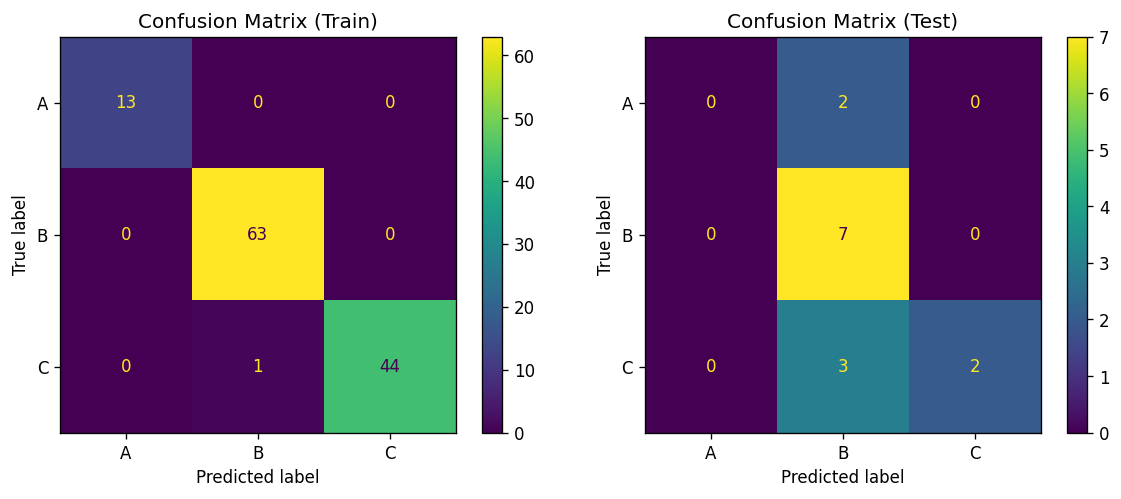

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        13
           B       0.98      1.00      0.99        63
           C       1.00      0.98      0.99        45

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.58      1.00      0.74         7
           C       1.00      0.40      0.57         5

    accuracy                           0.64        14
   macro avg       0.53      0.47      0.44        14
weighted avg       0.65      0.64      0.57        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,KNeighborsClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
1,KNeighborsClassifier,Test,0.63152,0.64286,0.64881,0.64286,0.57250


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Support Vector Machine (One-vs-Rest)

In [ ]:
%%time
model_name = 'SupportVectorMachine'

param_grid = {
    'classifier__base_estimator__penalty': ['l1', 'l2'],
    'classifier__base_estimator__C': [0.1, 0.5, 1],
    'classifier__base_estimator__max_iter': [100, 200, 500, 1000, 5000, 10000],
    'classifier__base_estimator__multi_class': ['ovr'],
    'classifier__base_estimator__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', CalibratedClassifierCV(LinearSVC()))
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 586 ms, sys: 19.1 ms, total: 605 ms
Wall time: 16.6 s


{'classifier__base_estimator__C': 0.1,
 'classifier__base_estimator__max_iter': 100,
 'classifier__base_estimator__multi_class': 'ovr',
 'classifier__base_estimator__penalty': 'l2',
 'classifier__base_estimator__random_state': 54}

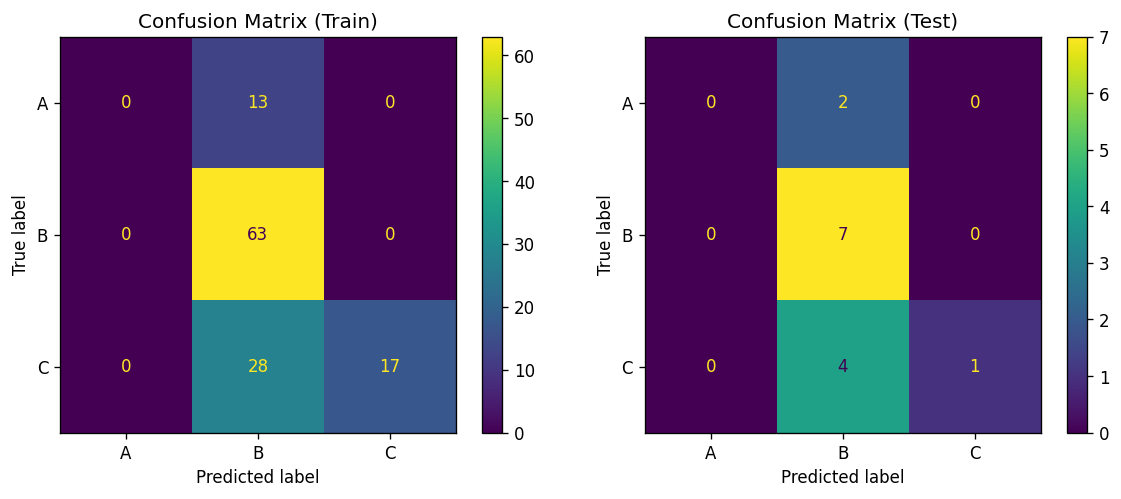

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        13
           B       0.61      1.00      0.75        63
           C       1.00      0.38      0.55        45

    accuracy                           0.66       121
   macro avg       0.54      0.46      0.43       121
weighted avg       0.69      0.66      0.60       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.54      1.00      0.70         7
           C       1.00      0.20      0.33         5

    accuracy                           0.57        14
   macro avg       0.51      0.40      0.34        14
weighted avg       0.63      0.57      0.47        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,SupportVectorMachine,Train,0.78118,0.66116,0.68730,0.66116,0.59678
1,SupportVectorMachine,Test,0.73866,0.57143,0.62637,0.57143,0.46905


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Logistic Regression (One-vs-Rest)

In [ ]:
%%time
model_name = 'LogisticRegression'

param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__Cs': [1, 10],
    'classifier__max_iter': [10, 100, 200, 500],
    'classifier__solver' : ['lbfgs'],
    'classifier__multi_class': ['ovr'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', LogisticRegressionCV())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 845 ms, sys: 44.3 ms, total: 890 ms
Wall time: 33.2 s


{'classifier__Cs': 10,
 'classifier__max_iter': 10,
 'classifier__multi_class': 'ovr',
 'classifier__penalty': 'l2',
 'classifier__random_state': 54,
 'classifier__solver': 'lbfgs'}

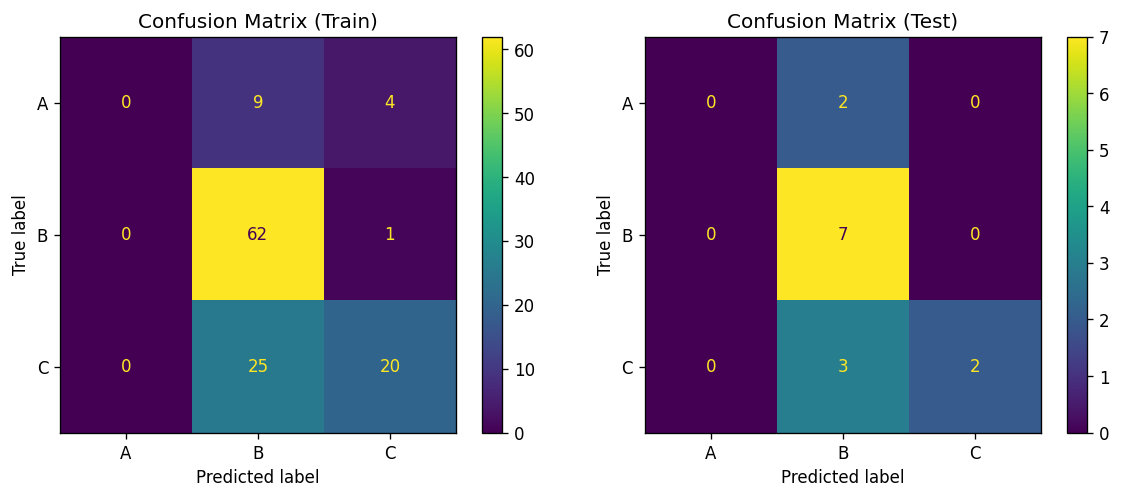

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        13
           B       0.65      0.98      0.78        63
           C       0.80      0.44      0.57        45

    accuracy                           0.68       121
   macro avg       0.48      0.48      0.45       121
weighted avg       0.63      0.68      0.62       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.58      1.00      0.74         7
           C       1.00      0.40      0.57         5

    accuracy                           0.64        14
   macro avg       0.53      0.47      0.44        14
weighted avg       0.65      0.64      0.57        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,LogisticRegression,Train,0.75025,0.67769,0.63378,0.67769,0.61856
1,LogisticRegression,Test,0.75510,0.64286,0.64881,0.64286,0.57250


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Decision Tree Classifier

In [ ]:
%%time
model_name = 'DecisionTreeClassifier'

param_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [None, 5, 10, 50, 100, 500, 1000],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', DecisionTreeClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 353 ms, sys: 99 ms, total: 452 ms
Wall time: 4.99 s


{'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__random_state': 54}

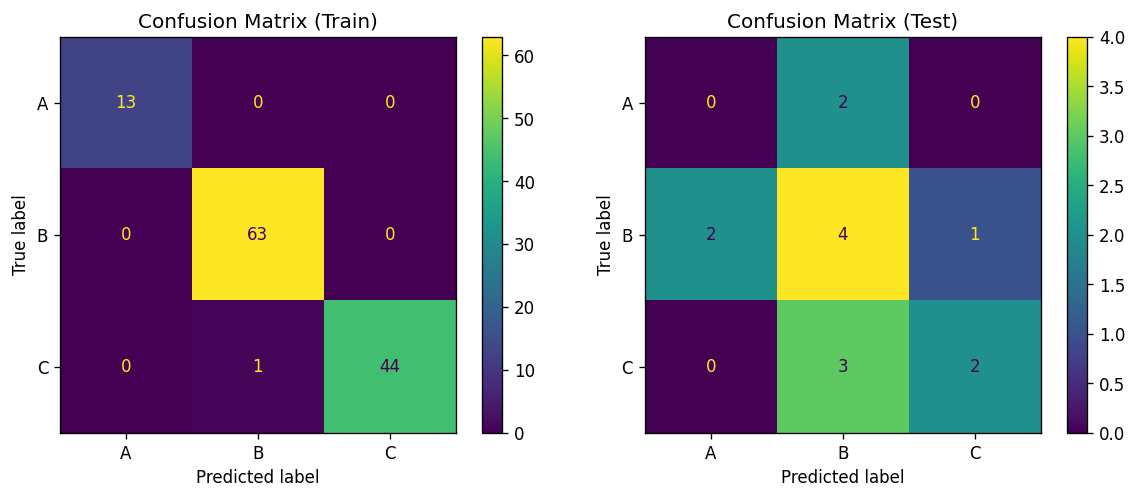

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        13
           B       0.98      1.00      0.99        63
           C       1.00      0.98      0.99        45

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.44      0.57      0.50         7
           C       0.67      0.40      0.50         5

    accuracy                           0.43        14
   macro avg       0.37      0.32      0.33        14
weighted avg       0.46      0.43      0.43        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,DecisionTreeClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
1,DecisionTreeClassifier,Test,0.50397,0.42857,0.46032,0.42857,0.42857


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Extra Trees Classifier

In [ ]:
%%time
model_name = 'ExtraTreesClassifier'

param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__criterion': ['gini'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', ExtraTreesClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 318 ms, sys: 12.7 ms, total: 331 ms
Wall time: 7.75 s


{'classifier__criterion': 'gini',
 'classifier__n_estimators': 100,
 'classifier__random_state': 54}

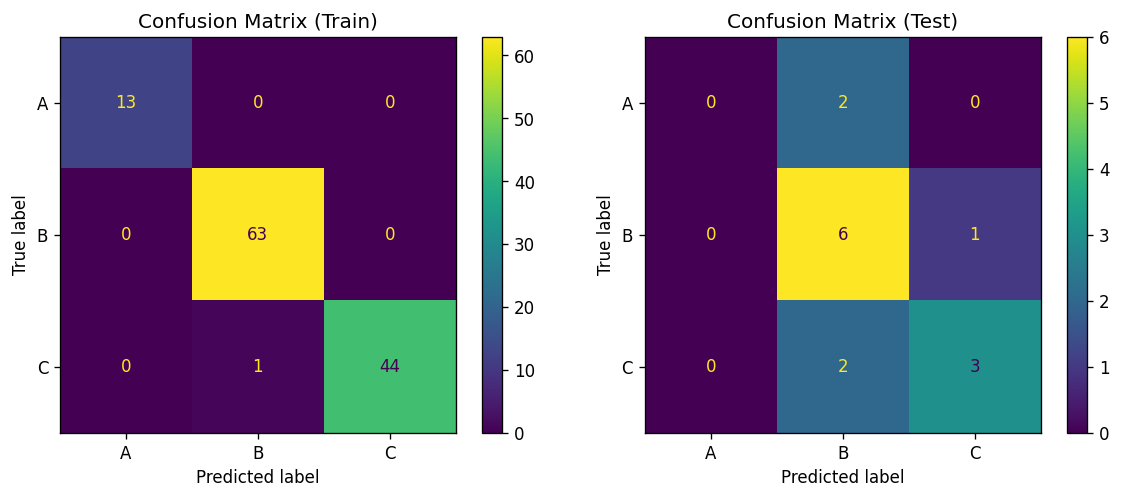

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        13
           B       0.98      1.00      0.99        63
           C       1.00      0.98      0.99        45

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.60      0.86      0.71         7
           C       0.75      0.60      0.67         5

    accuracy                           0.64        14
   macro avg       0.45      0.49      0.46        14
weighted avg       0.57      0.64      0.59        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,ExtraTreesClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
1,ExtraTreesClassifier,Test,0.70918,0.64286,0.56786,0.64286,0.59104


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Random Forest Classifier

In [ ]:
%%time
model_name = 'RandomForestClassifier'

param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', RandomForestClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 1.71 s, sys: 30.8 ms, total: 1.74 s
Wall time: 23.3 s


{'classifier__criterion': 'gini',
 'classifier__n_estimators': 500,
 'classifier__random_state': 54}

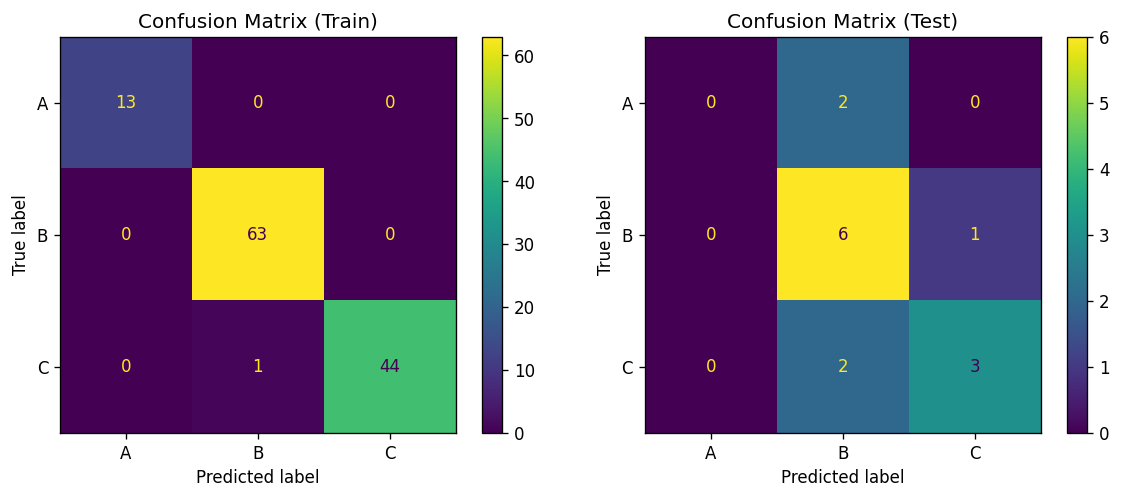

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        13
           B       0.98      1.00      0.99        63
           C       1.00      0.98      0.99        45

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.60      0.86      0.71         7
           C       0.75      0.60      0.67         5

    accuracy                           0.64        14
   macro avg       0.45      0.49      0.46        14
weighted avg       0.57      0.64      0.59        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,RandomForestClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
1,RandomForestClassifier,Test,0.76644,0.64286,0.56786,0.64286,0.59104


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Gradient Boosting Classifier

In [ ]:
%%time
model_name = 'GradientBoostingClassifier'

param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200, 500],
    'classifier__max_depth': [None, 3, 10, 20],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', GradientBoostingClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 2.23 s, sys: 87.7 ms, total: 2.32 s
Wall time: 1min 59s


{'classifier__max_depth': 3,
 'classifier__n_estimators': 100,
 'classifier__random_state': 54}

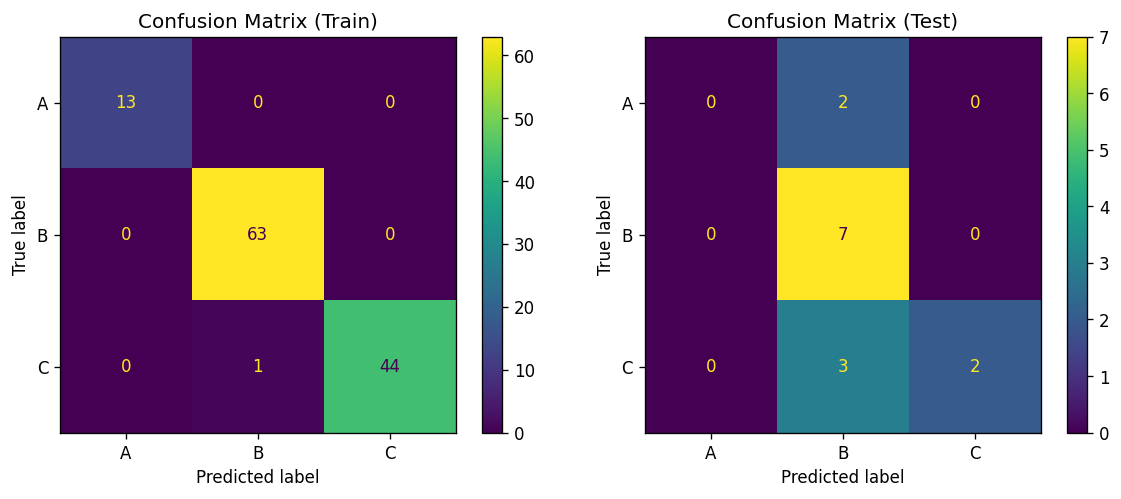

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        13
           B       0.98      1.00      0.99        63
           C       1.00      0.98      0.99        45

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.58      1.00      0.74         7
           C       1.00      0.40      0.57         5

    accuracy                           0.64        14
   macro avg       0.53      0.47      0.44        14
weighted avg       0.65      0.64      0.57        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GradientBoostingClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
1,GradientBoostingClassifier,Test,0.68112,0.64286,0.64881,0.64286,0.57250


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Сводная результатов эксперимента

In [ ]:
models = [
    'GaussianNaiveBayes', 'KNeighborsClassifier', 'SupportVectorMachine', 'LogisticRegression',
    'DecisionTreeClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier'
]

results = pd.DataFrame()

for model in models:
    res = pd.read_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model}.xlsx')
    results = results.append(res)

results = results.reset_index(drop=True)
results.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_results.xlsx', index=False)
results

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GaussianNaiveBayes,Train,0.66807,0.62810,0.63017,0.62810,0.60811
1,GaussianNaiveBayes,Test,0.50340,0.42857,0.36508,0.42857,0.39286
2,KNeighborsClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
3,KNeighborsClassifier,Test,0.63152,0.64286,0.64881,0.64286,0.57250
4,SupportVectorMachine,Train,0.78118,0.66116,0.68730,0.66116,0.59678
5,SupportVectorMachine,Test,0.73866,0.57143,0.62637,0.57143,0.46905
6,LogisticRegression,Train,0.75025,0.67769,0.63378,0.67769,0.61856
7,LogisticRegression,Test,0.75510,0.64286,0.64881,0.64286,0.57250
8,DecisionTreeClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
9,DecisionTreeClassifier,Test,0.50397,0.42857,0.46032,0.42857,0.42857


#### Предсказание от лучшей модели

In [ ]:
%%time
model_name = 'RandomForestClassifier'

param_grid = {
    'classifier__n_estimators': [500],
    'classifier__criterion': ['gini'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', RandomForestClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

CPU times: user 1.94 s, sys: 14.2 ms, total: 1.95 s
Wall time: 16 s


In [ ]:
final_res = features_data.loc[y_test.index][['company', target]]
final_res[f'Prediction({target})'] = y_pred_test
final_res[f'Probability({target})=A'] = y_pred_probs_test[:, 0]
final_res[f'Probability({target})=B'] = y_pred_probs_test[:, 1]
final_res[f'Probability({target})=C'] = y_pred_probs_test[:, 2]
final_res.reset_index(drop=True)

,company,ESG_Rating_band,Prediction(ESG_Rating_band),Probability(ESG_Rating_band)=A,Probability(ESG_Rating_band)=B,Probability(ESG_Rating_band)=C
0,ТГК-2,C,C,0.130,0.298000,0.572000
1,«Лента» (сеть гипермаркетов),B,B,0.224,0.435333,0.340667
2,«Первая грузовая компания»,B,B,0.076,0.730000,0.194000
3,Газпромбанк,B,B,0.140,0.786000,0.074000
4,«Ямал СПГ»,C,C,0.098,0.138000,0.764000
5,"«ЕвроХим», группа",B,B,0.142,0.432000,0.426000
6,ЧФМК,C,C,0.176,0.396000,0.428000
7,Globaltrans,B,B,0.064,0.562000,0.374000
8,Россельхозбанк,B,B,0.100,0.690000,0.210000
9,«Промышленно-металлургический холдинг» (ПМХ),C,B,0.064,0.538000,0.398000


In [ ]:
pd.DataFrame(
    [
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,RandomForestClassifier,Test,0.76644,0.64286,0.56786,0.64286,0.59104


In [ ]:
final_res.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_final_result.xlsx', index=False)

### Эксперимент №2.1: Вычисление E Rating band

In [ ]:
target = 'E_Rating_band'

X = features_data.drop(columns=['ESG_Rank', 'ESG_Rating_band', 'E_Rank', 'E_Rating_band', 'S_Rank', 'S_Rating_band', 'G_Rank', 'G_Rating_band', 'company'])
y = features_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=54, shuffle=True, stratify=y)

y.value_counts()

B    70
C    50
A    15
Name: E_Rating_band, dtype: int64

#### Gaussian Naive Bayes

In [ ]:
%%time
model_name = 'GaussianNaiveBayes'

param_grid = {}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', GaussianNB())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 66.8 ms, sys: 48.2 ms, total: 115 ms
Wall time: 1.69 s


{}

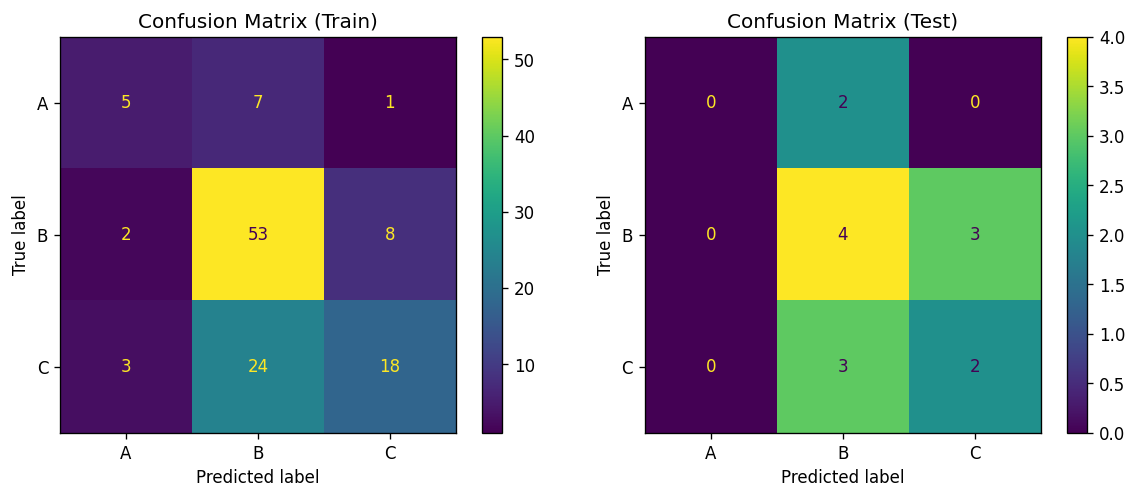

Train:
               precision    recall  f1-score   support

           A       0.50      0.38      0.43        13
           B       0.63      0.84      0.72        63
           C       0.67      0.40      0.50        45

    accuracy                           0.63       121
   macro avg       0.60      0.54      0.55       121
weighted avg       0.63      0.63      0.61       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.44      0.57      0.50         7
           C       0.40      0.40      0.40         5

    accuracy                           0.43        14
   macro avg       0.28      0.32      0.30        14
weighted avg       0.37      0.43      0.39        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GaussianNaiveBayes,Train,0.66807,0.62810,0.63017,0.62810,0.60811
1,GaussianNaiveBayes,Test,0.50340,0.42857,0.36508,0.42857,0.39286


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### K-Nearest Neighbors

In [ ]:
%%time
model_name = 'KNeighborsClassifier'

param_grid = {
    'classifier__n_neighbors': [5, 10, 20, 50, 100],
    'classifier__weights': ['uniform', 'distance'],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', KNeighborsClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 283 ms, sys: 43.7 ms, total: 327 ms
Wall time: 1.3 s


{'classifier__n_neighbors': 10, 'classifier__weights': 'distance'}

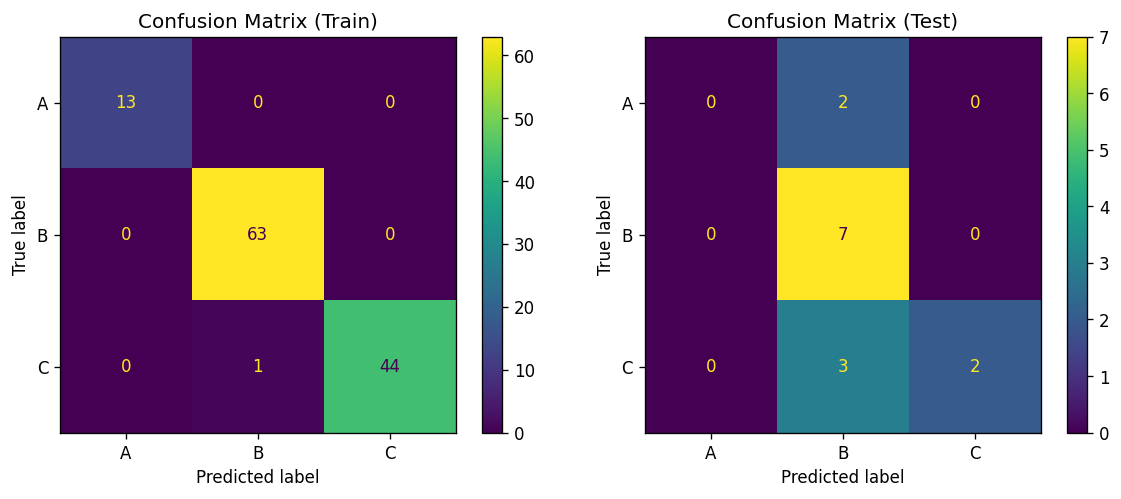

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        13
           B       0.98      1.00      0.99        63
           C       1.00      0.98      0.99        45

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.58      1.00      0.74         7
           C       1.00      0.40      0.57         5

    accuracy                           0.64        14
   macro avg       0.53      0.47      0.44        14
weighted avg       0.65      0.64      0.57        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,KNeighborsClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
1,KNeighborsClassifier,Test,0.63152,0.64286,0.64881,0.64286,0.57250


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Support Vector Machine (One-vs-Rest)

In [ ]:
%%time
model_name = 'SupportVectorMachine'

param_grid = {
    'classifier__base_estimator__penalty': ['l1', 'l2'],
    'classifier__base_estimator__C': [0.1, 0.5, 1],
    'classifier__base_estimator__max_iter': [100, 200, 500, 1000, 5000, 10000],
    'classifier__base_estimator__multi_class': ['ovr'],
    'classifier__base_estimator__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', CalibratedClassifierCV(LinearSVC()))
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 734 ms, sys: 16.8 ms, total: 751 ms
Wall time: 24.5 s


{'classifier__base_estimator__C': 0.1,
 'classifier__base_estimator__max_iter': 100,
 'classifier__base_estimator__multi_class': 'ovr',
 'classifier__base_estimator__penalty': 'l2',
 'classifier__base_estimator__random_state': 54}

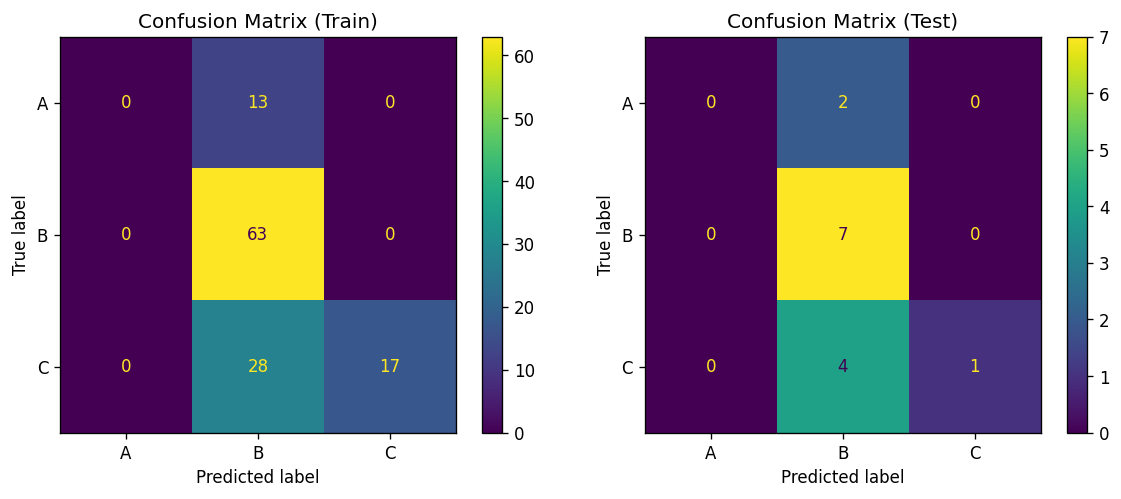

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        13
           B       0.61      1.00      0.75        63
           C       1.00      0.38      0.55        45

    accuracy                           0.66       121
   macro avg       0.54      0.46      0.43       121
weighted avg       0.69      0.66      0.60       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.54      1.00      0.70         7
           C       1.00      0.20      0.33         5

    accuracy                           0.57        14
   macro avg       0.51      0.40      0.34        14
weighted avg       0.63      0.57      0.47        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,SupportVectorMachine,Train,0.78118,0.66116,0.68730,0.66116,0.59678
1,SupportVectorMachine,Test,0.73866,0.57143,0.62637,0.57143,0.46905


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Logistic Regression (One-vs-Rest)

In [ ]:
%%time
model_name = 'LogisticRegression'

param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__Cs': [1, 10],
    'classifier__max_iter': [10, 100, 200, 500],
    'classifier__solver' : ['lbfgs'],
    'classifier__multi_class': ['ovr'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', LogisticRegressionCV())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 1.22 s, sys: 40.8 ms, total: 1.26 s
Wall time: 44.6 s


{'classifier__Cs': 10,
 'classifier__max_iter': 10,
 'classifier__multi_class': 'ovr',
 'classifier__penalty': 'l2',
 'classifier__random_state': 54,
 'classifier__solver': 'lbfgs'}

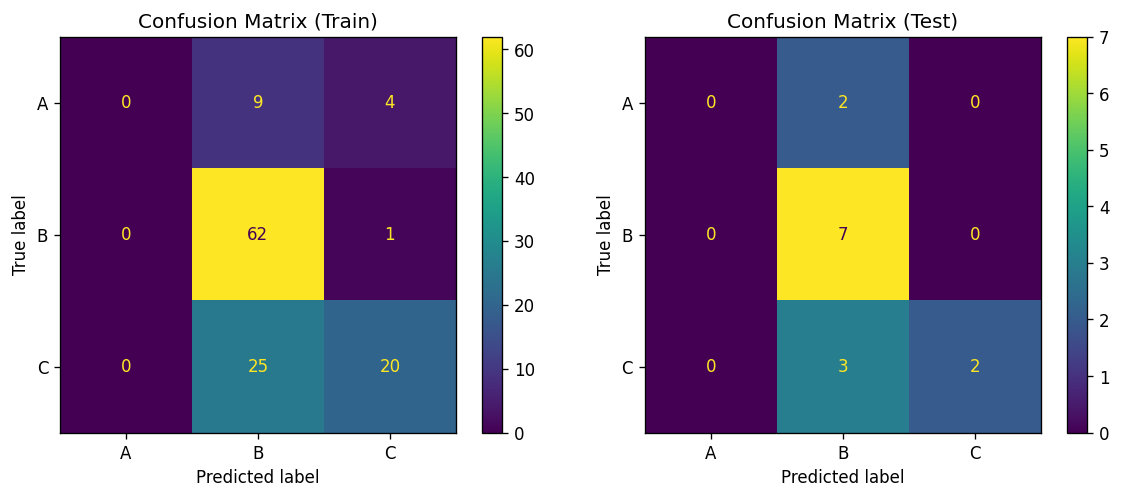

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        13
           B       0.65      0.98      0.78        63
           C       0.80      0.44      0.57        45

    accuracy                           0.68       121
   macro avg       0.48      0.48      0.45       121
weighted avg       0.63      0.68      0.62       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.58      1.00      0.74         7
           C       1.00      0.40      0.57         5

    accuracy                           0.64        14
   macro avg       0.53      0.47      0.44        14
weighted avg       0.65      0.64      0.57        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,LogisticRegression,Train,0.75025,0.67769,0.63378,0.67769,0.61856
1,LogisticRegression,Test,0.75510,0.64286,0.64881,0.64286,0.57250


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Decision Tree Classifier

In [ ]:
%%time
model_name = 'DecisionTreeClassifier'

param_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [None, 5, 10, 50, 100, 500, 1000],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', DecisionTreeClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 233 ms, sys: 6.85 ms, total: 240 ms
Wall time: 1.43 s


{'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__random_state': 54}

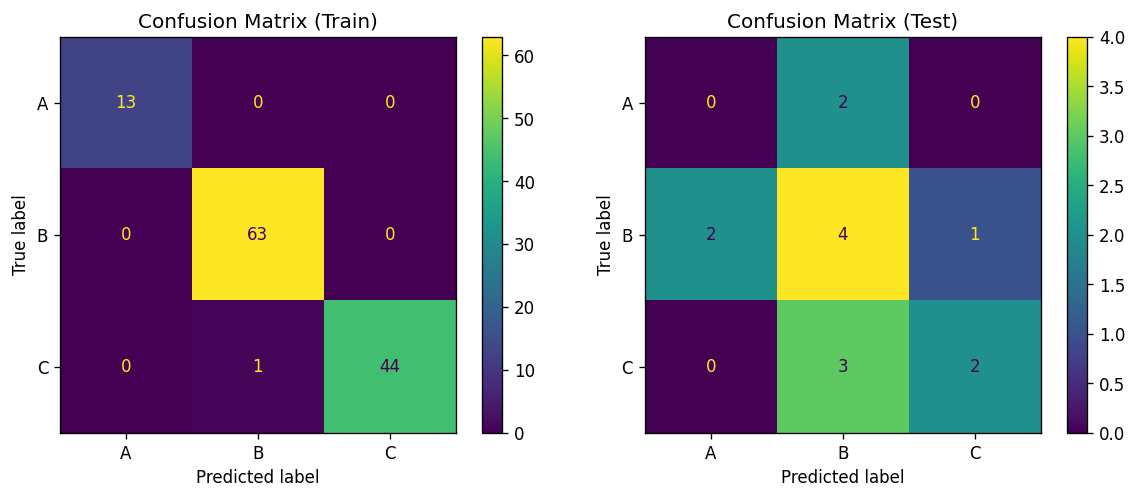

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        13
           B       0.98      1.00      0.99        63
           C       1.00      0.98      0.99        45

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.44      0.57      0.50         7
           C       0.67      0.40      0.50         5

    accuracy                           0.43        14
   macro avg       0.37      0.32      0.33        14
weighted avg       0.46      0.43      0.43        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,DecisionTreeClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
1,DecisionTreeClassifier,Test,0.50397,0.42857,0.46032,0.42857,0.42857


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Extra Trees Classifier

In [ ]:
%%time
model_name = 'ExtraTreesClassifier'

param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__criterion': ['gini'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', ExtraTreesClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 287 ms, sys: 7.47 ms, total: 295 ms
Wall time: 4.86 s


{'classifier__criterion': 'gini',
 'classifier__n_estimators': 100,
 'classifier__random_state': 54}

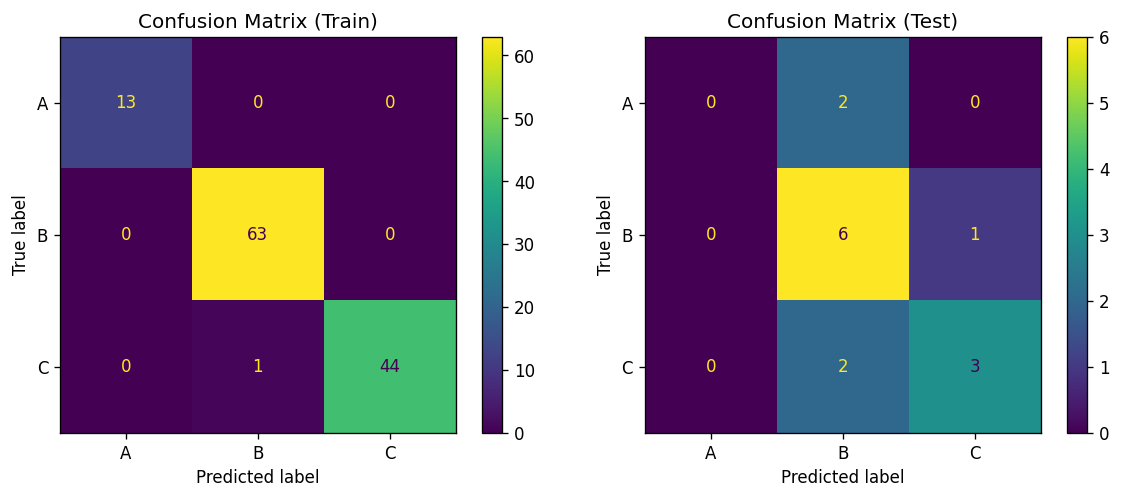

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        13
           B       0.98      1.00      0.99        63
           C       1.00      0.98      0.99        45

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.60      0.86      0.71         7
           C       0.75      0.60      0.67         5

    accuracy                           0.64        14
   macro avg       0.45      0.49      0.46        14
weighted avg       0.57      0.64      0.59        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,ExtraTreesClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
1,ExtraTreesClassifier,Test,0.70918,0.64286,0.56786,0.64286,0.59104


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Random Forest Classifier

In [ ]:
%%time
model_name = 'RandomForestClassifier'

param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', RandomForestClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 2.11 s, sys: 30.9 ms, total: 2.14 s
Wall time: 31.9 s


{'classifier__criterion': 'gini',
 'classifier__n_estimators': 500,
 'classifier__random_state': 54}

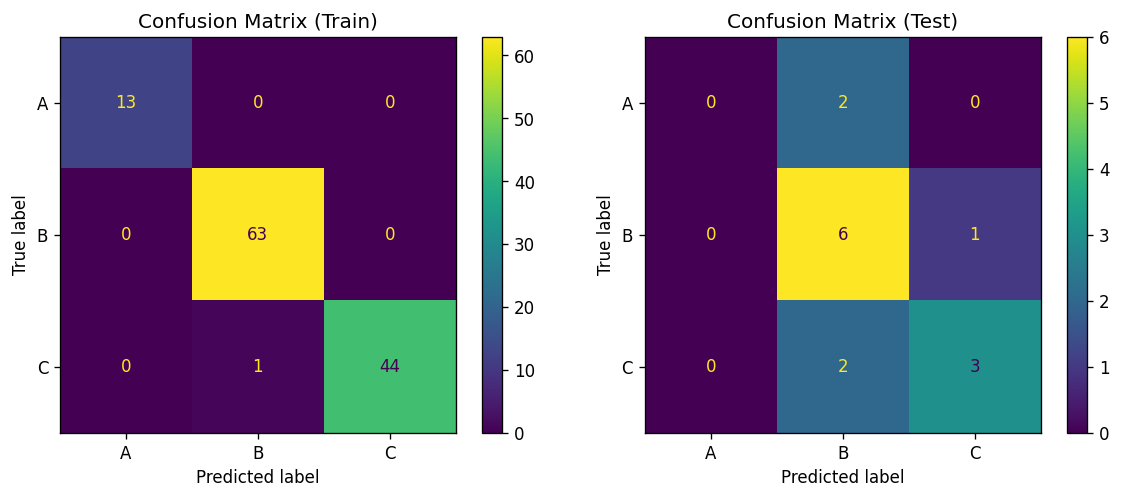

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        13
           B       0.98      1.00      0.99        63
           C       1.00      0.98      0.99        45

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.60      0.86      0.71         7
           C       0.75      0.60      0.67         5

    accuracy                           0.64        14
   macro avg       0.45      0.49      0.46        14
weighted avg       0.57      0.64      0.59        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,RandomForestClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
1,RandomForestClassifier,Test,0.76644,0.64286,0.56786,0.64286,0.59104


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Gradient Boosting Classifier

In [ ]:
%%time
model_name = 'GradientBoostingClassifier'

param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200, 500],
    'classifier__max_depth': [None, 3, 10, 20],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', GradientBoostingClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 1.97 s, sys: 106 ms, total: 2.07 s
Wall time: 2min 14s


{'classifier__max_depth': 3,
 'classifier__n_estimators': 100,
 'classifier__random_state': 54}

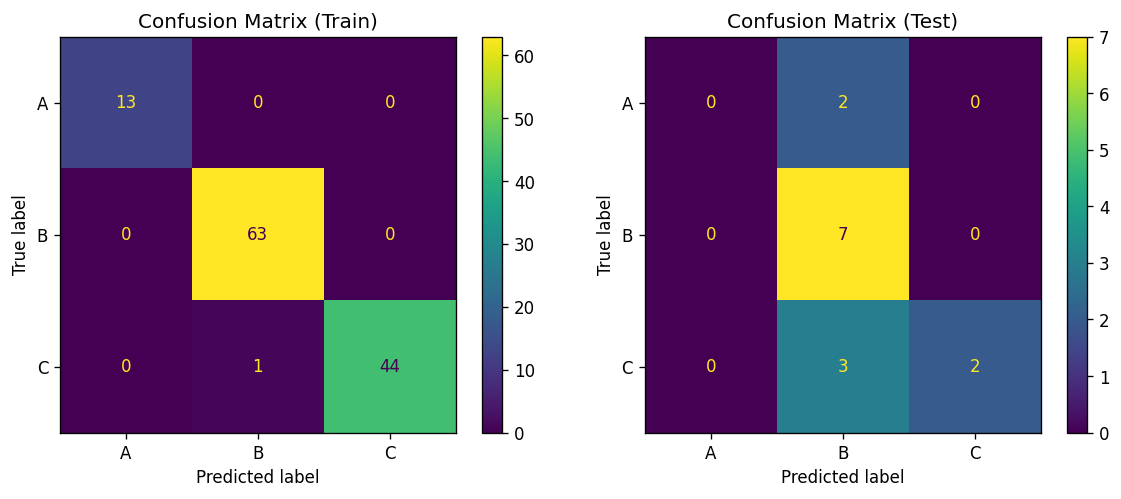

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        13
           B       0.98      1.00      0.99        63
           C       1.00      0.98      0.99        45

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.58      1.00      0.74         7
           C       1.00      0.40      0.57         5

    accuracy                           0.64        14
   macro avg       0.53      0.47      0.44        14
weighted avg       0.65      0.64      0.57        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GradientBoostingClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
1,GradientBoostingClassifier,Test,0.68112,0.64286,0.64881,0.64286,0.57250


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Сводная результатов эксперимента

In [ ]:
models = [
    'GaussianNaiveBayes', 'KNeighborsClassifier', 'SupportVectorMachine', 'LogisticRegression',
    'DecisionTreeClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier'
]

results = pd.DataFrame()

for model in models:
    res = pd.read_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model}.xlsx')
    results = results.append(res)

results = results.reset_index(drop=True)
results.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_results.xlsx', index=False)
results

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GaussianNaiveBayes,Train,0.66807,0.62810,0.63017,0.62810,0.60811
1,GaussianNaiveBayes,Test,0.50340,0.42857,0.36508,0.42857,0.39286
2,KNeighborsClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
3,KNeighborsClassifier,Test,0.63152,0.64286,0.64881,0.64286,0.57250
4,SupportVectorMachine,Train,0.78118,0.66116,0.68730,0.66116,0.59678
5,SupportVectorMachine,Test,0.73866,0.57143,0.62637,0.57143,0.46905
6,LogisticRegression,Train,0.75025,0.67769,0.63378,0.67769,0.61856
7,LogisticRegression,Test,0.75510,0.64286,0.64881,0.64286,0.57250
8,DecisionTreeClassifier,Train,0.99987,0.99174,0.99186,0.99174,0.99172
9,DecisionTreeClassifier,Test,0.50397,0.42857,0.46032,0.42857,0.42857


#### Предсказание от лучшей модели

In [ ]:
%%time
model_name = 'RandomForestClassifier'

param_grid = {
    'classifier__n_estimators': [500],
    'classifier__criterion': ['gini'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', RandomForestClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

CPU times: user 1.75 s, sys: 10.5 ms, total: 1.76 s
Wall time: 9.78 s


In [ ]:
final_res = features_data.loc[y_test.index][['company', target]]
final_res[f'Prediction({target})'] = y_pred_test
final_res[f'Probability({target})=A'] = y_pred_probs_test[:, 0]
final_res[f'Probability({target})=B'] = y_pred_probs_test[:, 1]
final_res[f'Probability({target})=C'] = y_pred_probs_test[:, 2]
final_res.reset_index(drop=True)

,company,E_Rating_band,Prediction(E_Rating_band),Probability(E_Rating_band)=A,Probability(E_Rating_band)=B,Probability(E_Rating_band)=C
0,ТГК-2,C,C,0.130,0.298000,0.572000
1,«Лента» (сеть гипермаркетов),B,B,0.224,0.435333,0.340667
2,«Первая грузовая компания»,B,B,0.076,0.730000,0.194000
3,Газпромбанк,B,B,0.140,0.786000,0.074000
4,«Ямал СПГ»,C,C,0.098,0.138000,0.764000
5,"«ЕвроХим», группа",B,B,0.142,0.432000,0.426000
6,ЧФМК,C,C,0.176,0.396000,0.428000
7,Globaltrans,B,B,0.064,0.562000,0.374000
8,Россельхозбанк,B,B,0.100,0.690000,0.210000
9,«Промышленно-металлургический холдинг» (ПМХ),C,B,0.064,0.538000,0.398000


In [ ]:
pd.DataFrame(
    [
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,RandomForestClassifier,Test,0.76644,0.64286,0.56786,0.64286,0.59104


In [ ]:
final_res.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_final_result.xlsx', index=False)

### Эксперимент №2.2: Вычисление S Rating band

In [68]:
target = 'S_Rating_band'

X = features_data.drop(columns=['ESG_Rank', 'ESG_Rating_band', 'E_Rank', 'E_Rating_band', 'S_Rank', 'S_Rating_band', 'G_Rank', 'G_Rating_band', 'company'])
y = features_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=54, shuffle=True, stratify=y)

y.value_counts()

B    61
C    56
A    18
Name: S_Rating_band, dtype: int64

#### Gaussian Naive Bayes

In [ ]:
%%time
model_name = 'GaussianNaiveBayes'

param_grid = {}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', GaussianNB())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 60.2 ms, sys: 1.04 ms, total: 61.2 ms
Wall time: 177 ms


{}

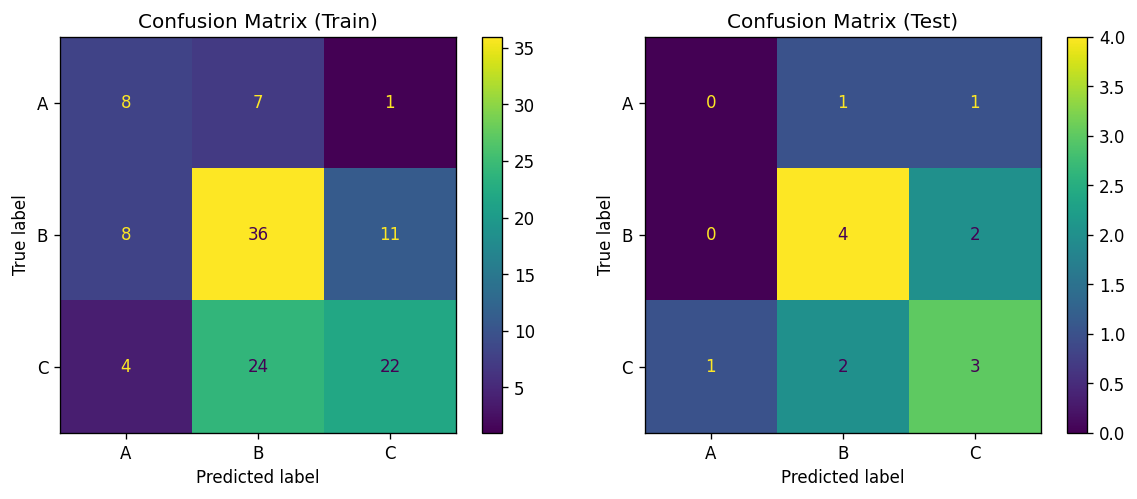

Train:
               precision    recall  f1-score   support

           A       0.40      0.50      0.44        16
           B       0.54      0.65      0.59        55
           C       0.65      0.44      0.52        50

    accuracy                           0.55       121
   macro avg       0.53      0.53      0.52       121
weighted avg       0.56      0.55      0.54       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.57      0.67      0.62         6
           C       0.50      0.50      0.50         6

    accuracy                           0.50        14
   macro avg       0.36      0.39      0.37        14
weighted avg       0.46      0.50      0.48        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GaussianNaiveBayes,Train,0.65155,0.54545,0.56451,0.54545,0.54348
1,GaussianNaiveBayes,Test,0.57887,0.50000,0.45918,0.50000,0.47802


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### K-Nearest Neighbors

In [ ]:
%%time
model_name = 'KNeighborsClassifier'

param_grid = {
    'classifier__n_neighbors': [5, 10, 20, 50, 100],
    'classifier__weights': ['uniform', 'distance'],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', KNeighborsClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 371 ms, sys: 4.17 ms, total: 375 ms
Wall time: 2.72 s


{'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}

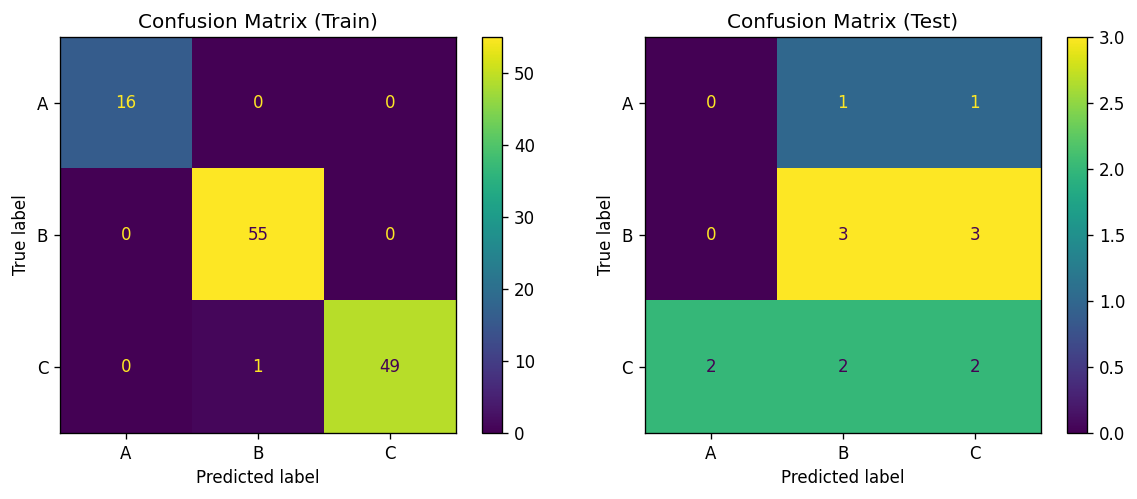

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        16
           B       0.98      1.00      0.99        55
           C       1.00      0.98      0.99        50

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.50      0.50      0.50         6
           C       0.33      0.33      0.33         6

    accuracy                           0.36        14
   macro avg       0.28      0.28      0.28        14
weighted avg       0.36      0.36      0.36        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,KNeighborsClassifier,Train,0.99988,0.99174,0.99188,0.99174,0.99173
1,KNeighborsClassifier,Test,0.40476,0.35714,0.35714,0.35714,0.35714


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Support Vector Machine (One-vs-Rest)

In [ ]:
%%time
model_name = 'SupportVectorMachine'

param_grid = {
    'classifier__base_estimator__penalty': ['l1', 'l2'],
    'classifier__base_estimator__C': [0.1, 0.5, 1],
    'classifier__base_estimator__max_iter': [100, 200, 500, 1000, 5000, 10000],
    'classifier__base_estimator__multi_class': ['ovr'],
    'classifier__base_estimator__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', CalibratedClassifierCV(LinearSVC()))
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 929 ms, sys: 30.1 ms, total: 959 ms
Wall time: 31 s


{'classifier__base_estimator__C': 0.1,
 'classifier__base_estimator__max_iter': 100,
 'classifier__base_estimator__multi_class': 'ovr',
 'classifier__base_estimator__penalty': 'l2',
 'classifier__base_estimator__random_state': 54}

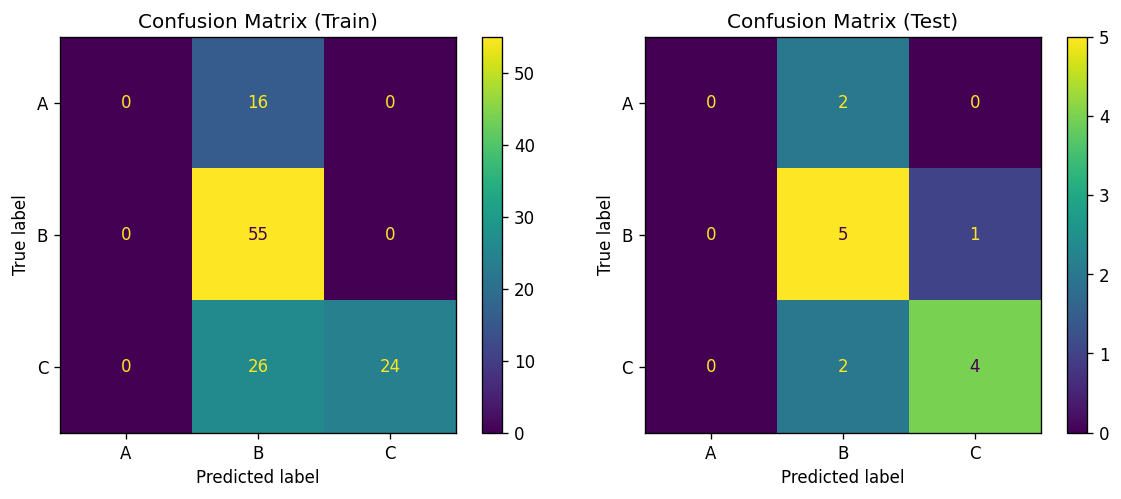

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        16
           B       0.57      1.00      0.72        55
           C       1.00      0.48      0.65        50

    accuracy                           0.65       121
   macro avg       0.52      0.49      0.46       121
weighted avg       0.67      0.65      0.60       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.56      0.83      0.67         6
           C       0.80      0.67      0.73         6

    accuracy                           0.64        14
   macro avg       0.45      0.50      0.46        14
weighted avg       0.58      0.64      0.60        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,SupportVectorMachine,Train,0.81000,0.65289,0.67096,0.65289,0.59698
1,SupportVectorMachine,Test,0.70238,0.64286,0.58095,0.64286,0.59740


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Logistic Regression (One-vs-Rest)

In [ ]:
%%time
model_name = 'LogisticRegression'

param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__Cs': [1, 10],
    'classifier__max_iter': [10, 100, 200, 500],
    'classifier__solver' : ['lbfgs'],
    'classifier__multi_class': ['ovr'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', LogisticRegressionCV())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 1.32 s, sys: 38.7 ms, total: 1.35 s
Wall time: 52.1 s


{'classifier__Cs': 10,
 'classifier__max_iter': 10,
 'classifier__multi_class': 'ovr',
 'classifier__penalty': 'l2',
 'classifier__random_state': 54,
 'classifier__solver': 'lbfgs'}

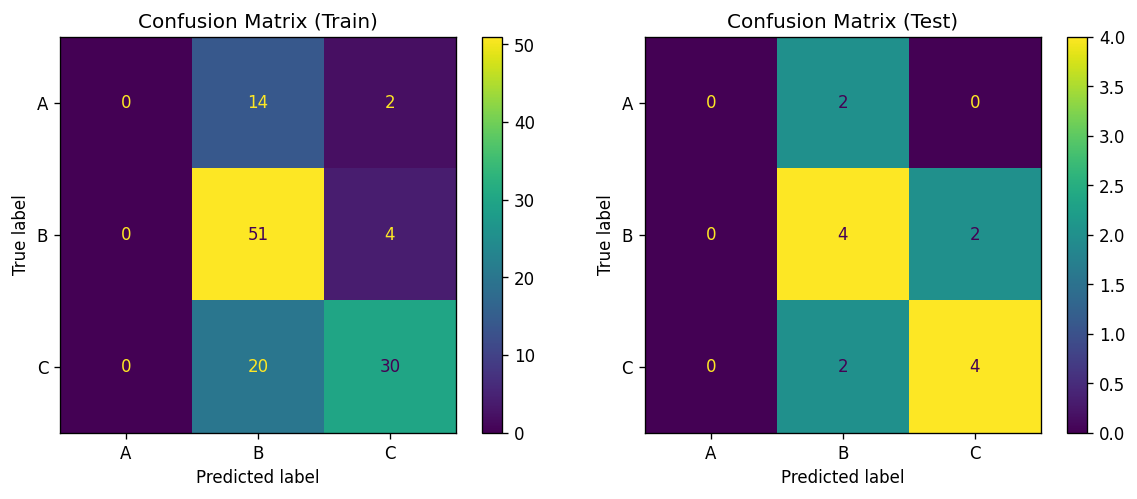

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        16
           B       0.60      0.93      0.73        55
           C       0.83      0.60      0.70        50

    accuracy                           0.67       121
   macro avg       0.48      0.51      0.48       121
weighted avg       0.62      0.67      0.62       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.50      0.67      0.57         6
           C       0.67      0.67      0.67         6

    accuracy                           0.57        14
   macro avg       0.39      0.44      0.41        14
weighted avg       0.50      0.57      0.53        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,LogisticRegression,Train,0.80980,0.66942,0.61708,0.66942,0.61946
1,LogisticRegression,Test,0.63988,0.57143,0.50000,0.57143,0.53061


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Decision Tree Classifier

In [ ]:
%%time
model_name = 'DecisionTreeClassifier'

param_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [None, 5, 10, 50, 100, 500, 1000],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', DecisionTreeClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 255 ms, sys: 7.41 ms, total: 263 ms
Wall time: 2.18 s


{'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__random_state': 54}

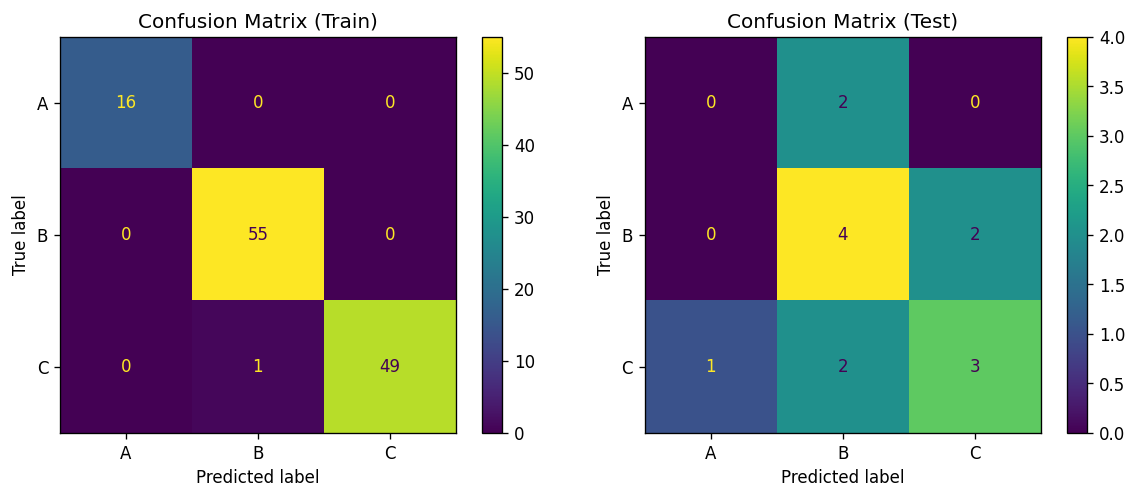

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        16
           B       0.98      1.00      0.99        55
           C       1.00      0.98      0.99        50

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.50      0.67      0.57         6
           C       0.60      0.50      0.55         6

    accuracy                           0.50        14
   macro avg       0.37      0.39      0.37        14
weighted avg       0.47      0.50      0.48        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,DecisionTreeClassifier,Train,0.99988,0.99174,0.99188,0.99174,0.99173
1,DecisionTreeClassifier,Test,0.58333,0.50000,0.47143,0.50000,0.47866


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Extra Trees Classifier

In [ ]:
%%time
model_name = 'ExtraTreesClassifier'

param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__criterion': ['gini'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', ExtraTreesClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 992 ms, sys: 15.1 ms, total: 1.01 s
Wall time: 5.55 s


{'classifier__criterion': 'gini',
 'classifier__n_estimators': 500,
 'classifier__random_state': 54}

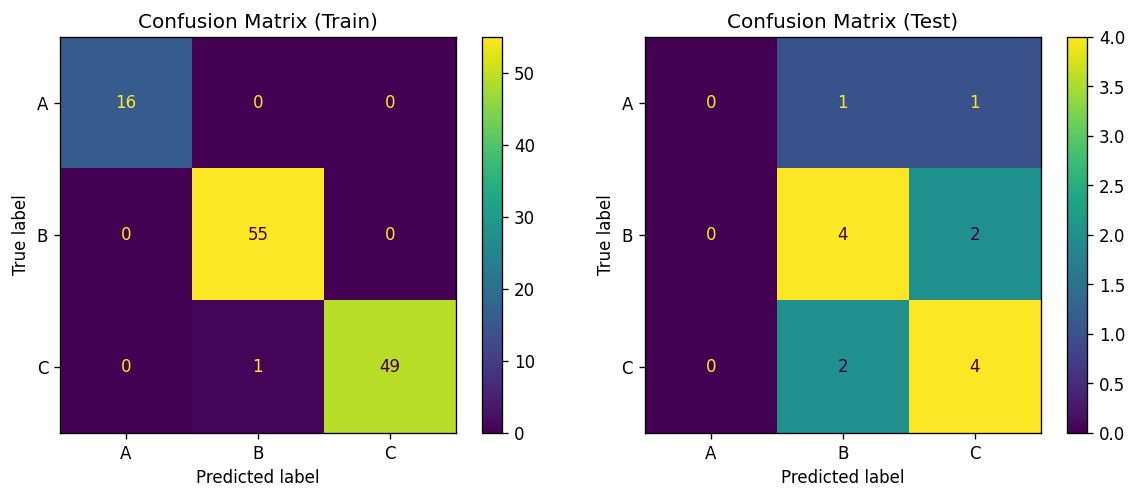

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        16
           B       0.98      1.00      0.99        55
           C       1.00      0.98      0.99        50

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.57      0.67      0.62         6
           C       0.57      0.67      0.62         6

    accuracy                           0.57        14
   macro avg       0.38      0.44      0.41        14
weighted avg       0.49      0.57      0.53        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,ExtraTreesClassifier,Train,0.99988,0.99174,0.99188,0.99174,0.99173
1,ExtraTreesClassifier,Test,0.60417,0.57143,0.48980,0.57143,0.52747


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Random Forest Classifier

In [ ]:
%%time
model_name = 'RandomForestClassifier'

param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', RandomForestClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 592 ms, sys: 23.7 ms, total: 616 ms
Wall time: 26.4 s


{'classifier__criterion': 'gini',
 'classifier__n_estimators': 100,
 'classifier__random_state': 54}

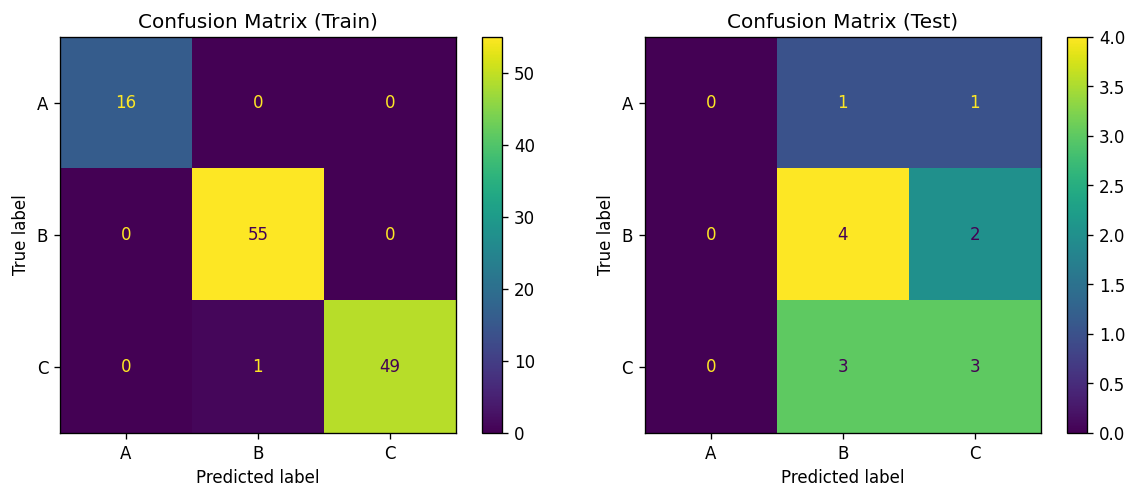

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        16
           B       0.98      1.00      0.99        55
           C       1.00      0.98      0.99        50

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.50      0.67      0.57         6
           C       0.50      0.50      0.50         6

    accuracy                           0.50        14
   macro avg       0.33      0.39      0.36        14
weighted avg       0.43      0.50      0.46        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,RandomForestClassifier,Train,0.99988,0.99174,0.99188,0.99174,0.99173
1,RandomForestClassifier,Test,0.53571,0.50000,0.42857,0.50000,0.45918


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Gradient Boosting Classifier

In [ ]:
%%time
model_name = 'GradientBoostingClassifier'

param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200, 500],
    'classifier__max_depth': [None, 3, 10, 20],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', GradientBoostingClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 1.33 s, sys: 103 ms, total: 1.43 s
Wall time: 2min 13s


{'classifier__max_depth': None,
 'classifier__n_estimators': 10,
 'classifier__random_state': 54}

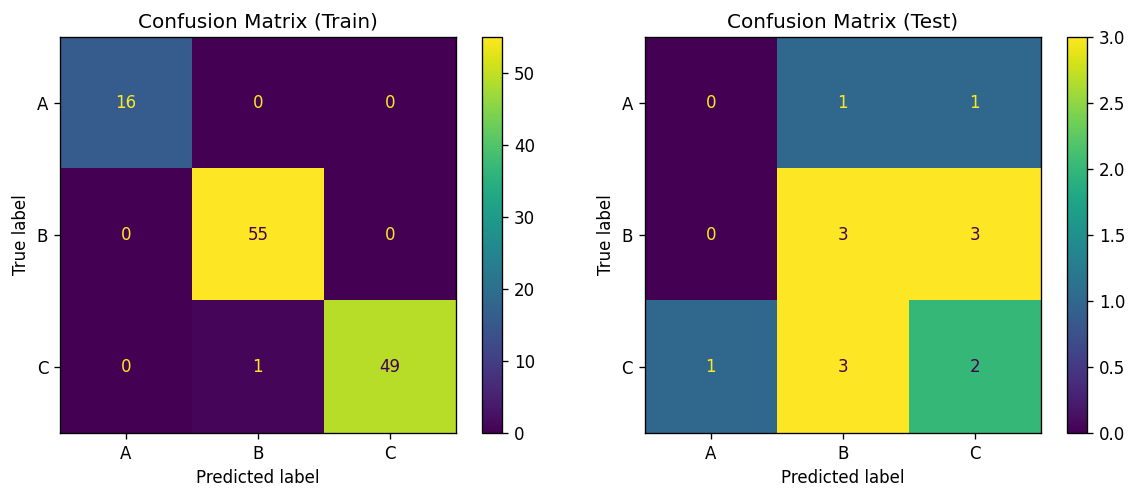

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        16
           B       0.98      1.00      0.99        55
           C       1.00      0.98      0.99        50

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.43      0.50      0.46         6
           C       0.33      0.33      0.33         6

    accuracy                           0.36        14
   macro avg       0.25      0.28      0.26        14
weighted avg       0.33      0.36      0.34        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GradientBoostingClassifier,Train,0.99988,0.99174,0.99188,0.99174,0.99173
1,GradientBoostingClassifier,Test,0.55952,0.35714,0.32653,0.35714,0.34066


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Сводная результатов эксперимента

In [ ]:
models = [
    'GaussianNaiveBayes', 'KNeighborsClassifier', 'SupportVectorMachine', 'LogisticRegression',
    'DecisionTreeClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier'
]

results = pd.DataFrame()

for model in models:
    res = pd.read_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model}.xlsx')
    results = results.append(res)

results = results.reset_index(drop=True)
results.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_results.xlsx', index=False)
results

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GaussianNaiveBayes,Train,0.65155,0.54545,0.56451,0.54545,0.54348
1,GaussianNaiveBayes,Test,0.57887,0.50000,0.45918,0.50000,0.47802
2,KNeighborsClassifier,Train,0.99988,0.99174,0.99188,0.99174,0.99173
3,KNeighborsClassifier,Test,0.40476,0.35714,0.35714,0.35714,0.35714
4,SupportVectorMachine,Train,0.81000,0.65289,0.67096,0.65289,0.59698
5,SupportVectorMachine,Test,0.70238,0.64286,0.58095,0.64286,0.59740
6,LogisticRegression,Train,0.80980,0.66942,0.61708,0.66942,0.61946
7,LogisticRegression,Test,0.63988,0.57143,0.50000,0.57143,0.53061
8,DecisionTreeClassifier,Train,0.99988,0.99174,0.99188,0.99174,0.99173
9,DecisionTreeClassifier,Test,0.58333,0.50000,0.47143,0.50000,0.47866


#### Предсказание от лучшей модели

In [69]:
%%time
model_name = 'SupportVectorMachine'

param_grid = {
    'classifier__base_estimator__penalty': ['l2'],
    'classifier__base_estimator__C': [0.1],
    'classifier__base_estimator__max_iter': [100],
    'classifier__base_estimator__multi_class': ['ovr'],
    'classifier__base_estimator__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', CalibratedClassifierCV(LinearSVC()))
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 649 ms


In [70]:
final_res = features_data.loc[y_test.index][['company', target]]
final_res[f'Prediction({target})'] = y_pred_test
final_res[f'Probability({target})=A'] = y_pred_probs_test[:, 0]
final_res[f'Probability({target})=B'] = y_pred_probs_test[:, 1]
final_res[f'Probability({target})=C'] = y_pred_probs_test[:, 2]
final_res.reset_index(drop=True)

,company,S_Rating_band,Prediction(S_Rating_band),Probability(S_Rating_band)=A,Probability(S_Rating_band)=B,Probability(S_Rating_band)=C
0,Сбербанк,B,B,0.103976,0.478844,0.417179
1,Россельхозбанк,C,B,0.149749,0.470060,0.380191
2,Башнефть,C,B,0.144890,0.476791,0.378319
3,«Ямал СПГ»,C,C,0.097706,0.342590,0.559703
4,"«Русал», объединенная компания",A,B,0.137663,0.458628,0.403709
5,«Тольяттиазот»,B,B,0.140133,0.472318,0.387549
6,Банк «Санкт-Петербург»,C,C,0.155940,0.420279,0.423782
7,«МегаФон»,B,C,0.140212,0.424333,0.435455
8,"ПАО ""МТС""",A,B,0.145667,0.503924,0.350409
9,"«ЕвроХим», группа",B,B,0.143555,0.477488,0.378958


In [71]:
pd.DataFrame(
    [
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,SupportVectorMachine,Test,0.70238,0.64286,0.58095,0.64286,0.5974


In [72]:
final_res.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_final_result.xlsx', index=False)

### Эксперимент №2.3: Вычисление G Rating band

In [ ]:
target = 'G_Rating_band'

X = features_data.drop(columns=['ESG_Rank', 'ESG_Rating_band', 'E_Rank', 'E_Rating_band', 'S_Rank', 'S_Rating_band', 'G_Rank', 'G_Rating_band', 'company'])
y = features_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=54, shuffle=True, stratify=y)

y.value_counts()

B    68
A    42
C    25
Name: G_Rating_band, dtype: int64

#### Gaussian Naive Bayes

In [ ]:
%%time
model_name = 'GaussianNaiveBayes'

param_grid = {}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', GaussianNB())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 43.9 ms, sys: 603 µs, total: 44.5 ms
Wall time: 93.4 ms


{}

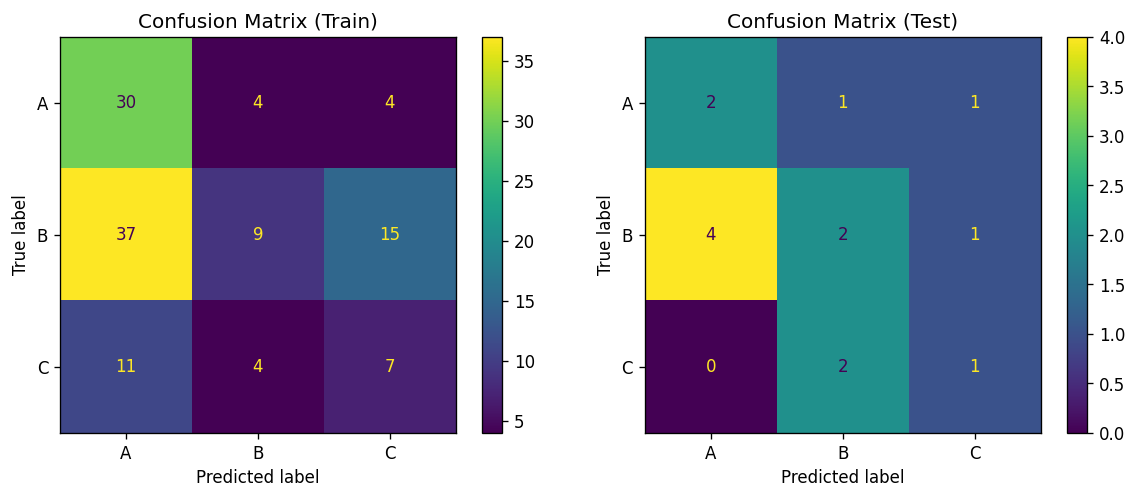

Train:
               precision    recall  f1-score   support

           A       0.38      0.79      0.52        38
           B       0.53      0.15      0.23        61
           C       0.27      0.32      0.29        22

    accuracy                           0.38       121
   macro avg       0.39      0.42      0.35       121
weighted avg       0.44      0.38      0.33       121

Test:
               precision    recall  f1-score   support

           A       0.33      0.50      0.40         4
           B       0.40      0.29      0.33         7
           C       0.33      0.33      0.33         3

    accuracy                           0.36        14
   macro avg       0.36      0.37      0.36        14
weighted avg       0.37      0.36      0.35        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GaussianNaiveBayes,Train,0.64631,0.38017,0.43663,0.38017,0.33181
1,GaussianNaiveBayes,Test,0.59879,0.35714,0.36667,0.35714,0.35238


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### K-Nearest Neighbors

In [ ]:
%%time
model_name = 'KNeighborsClassifier'

param_grid = {
    'classifier__n_neighbors': [5, 10, 20, 50, 100],
    'classifier__weights': ['uniform', 'distance'],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', KNeighborsClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 150 ms, sys: 8.99 ms, total: 159 ms
Wall time: 634 ms


{'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}

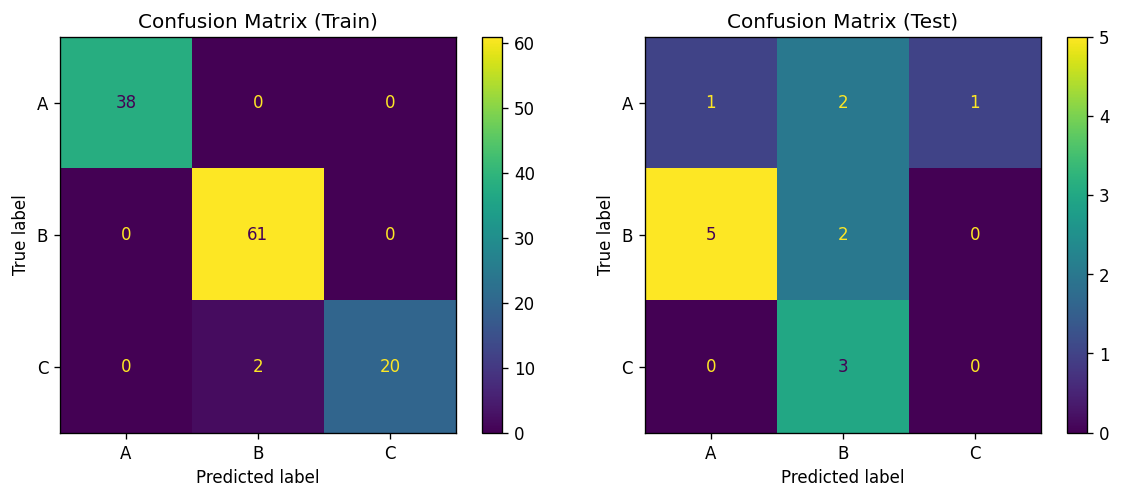

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        38
           B       0.97      1.00      0.98        61
           C       1.00      0.91      0.95        22

    accuracy                           0.98       121
   macro avg       0.99      0.97      0.98       121
weighted avg       0.98      0.98      0.98       121

Test:
               precision    recall  f1-score   support

           A       0.17      0.25      0.20         4
           B       0.29      0.29      0.29         7
           C       0.00      0.00      0.00         3

    accuracy                           0.21        14
   macro avg       0.15      0.18      0.16        14
weighted avg       0.19      0.21      0.20        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,KNeighborsClassifier,Train,0.99956,0.98347,0.98400,0.98347,0.98321
1,KNeighborsClassifier,Test,0.37486,0.21429,0.19048,0.21429,0.20000


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Support Vector Machine (One-vs-Rest)

In [ ]:
%%time
model_name = 'SupportVectorMachine'

param_grid = {
    'classifier__base_estimator__penalty': ['l1', 'l2'],
    'classifier__base_estimator__C': [0.1, 0.5, 1],
    'classifier__base_estimator__max_iter': [100, 200, 500, 1000, 5000, 10000],
    'classifier__base_estimator__multi_class': ['ovr'],
    'classifier__base_estimator__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', CalibratedClassifierCV(LinearSVC()))
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 567 ms, sys: 11.8 ms, total: 579 ms
Wall time: 17.8 s


{'classifier__base_estimator__C': 1,
 'classifier__base_estimator__max_iter': 100,
 'classifier__base_estimator__multi_class': 'ovr',
 'classifier__base_estimator__penalty': 'l2',
 'classifier__base_estimator__random_state': 54}

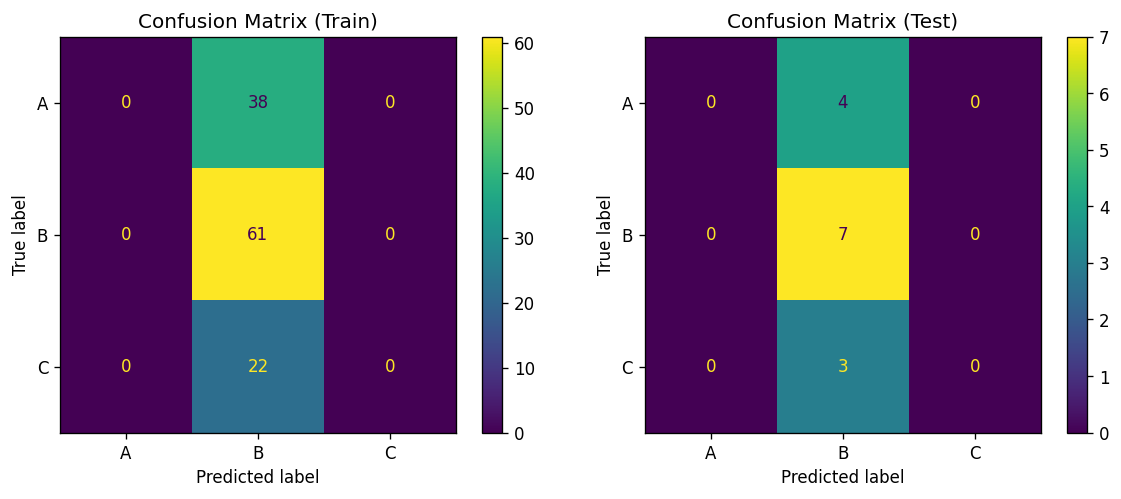

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        38
           B       0.50      1.00      0.67        61
           C       0.00      0.00      0.00        22

    accuracy                           0.50       121
   macro avg       0.17      0.33      0.22       121
weighted avg       0.25      0.50      0.34       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         4
           B       0.50      1.00      0.67         7
           C       0.00      0.00      0.00         3

    accuracy                           0.50        14
   macro avg       0.17      0.33      0.22        14
weighted avg       0.25      0.50      0.33        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,SupportVectorMachine,Train,0.55792,0.50413,0.25415,0.50413,0.33793
1,SupportVectorMachine,Test,0.50380,0.50000,0.25000,0.50000,0.33333


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Logistic Regression (One-vs-Rest)

In [ ]:
%%time
model_name = 'LogisticRegression'

param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__Cs': [1, 10],
    'classifier__max_iter': [10, 100, 200, 500],
    'classifier__solver' : ['lbfgs'],
    'classifier__multi_class': ['ovr'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', LogisticRegressionCV())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 678 ms, sys: 46 ms, total: 724 ms
Wall time: 49.7 s


{'classifier__Cs': 1,
 'classifier__max_iter': 10,
 'classifier__multi_class': 'ovr',
 'classifier__penalty': 'l2',
 'classifier__random_state': 54,
 'classifier__solver': 'lbfgs'}

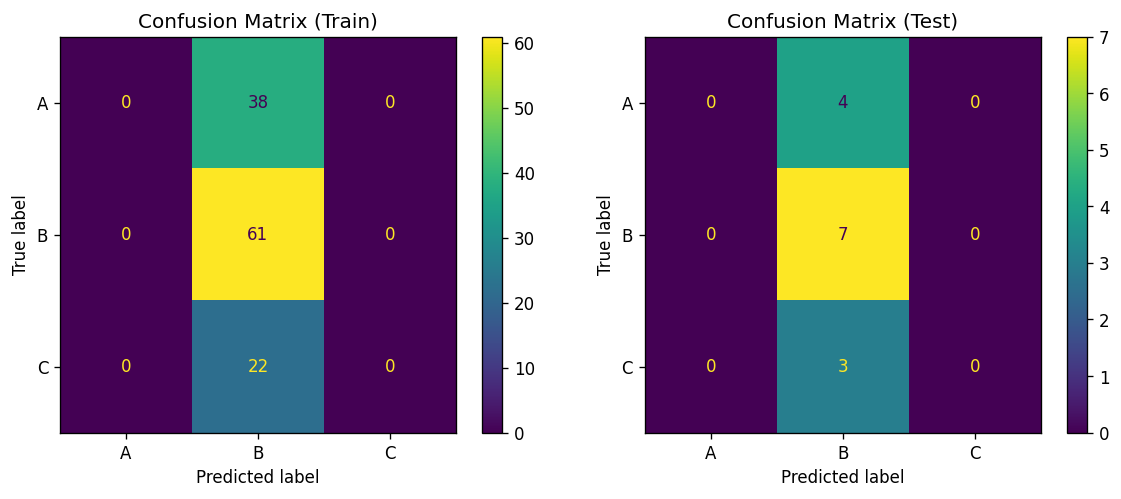

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        38
           B       0.50      1.00      0.67        61
           C       0.00      0.00      0.00        22

    accuracy                           0.50       121
   macro avg       0.17      0.33      0.22       121
weighted avg       0.25      0.50      0.34       121

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         4
           B       0.50      1.00      0.67         7
           C       0.00      0.00      0.00         3

    accuracy                           0.50        14
   macro avg       0.17      0.33      0.22        14
weighted avg       0.25      0.50      0.33        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,LogisticRegression,Train,0.63576,0.50413,0.25415,0.50413,0.33793
1,LogisticRegression,Test,0.66827,0.50000,0.25000,0.50000,0.33333


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Decision Tree Classifier

In [ ]:
%%time
model_name = 'DecisionTreeClassifier'

param_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [None, 5, 10, 50, 100, 500, 1000],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', DecisionTreeClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 352 ms, sys: 4.5 ms, total: 357 ms
Wall time: 4.53 s


{'classifier__criterion': 'gini',
 'classifier__max_depth': 5,
 'classifier__random_state': 54}

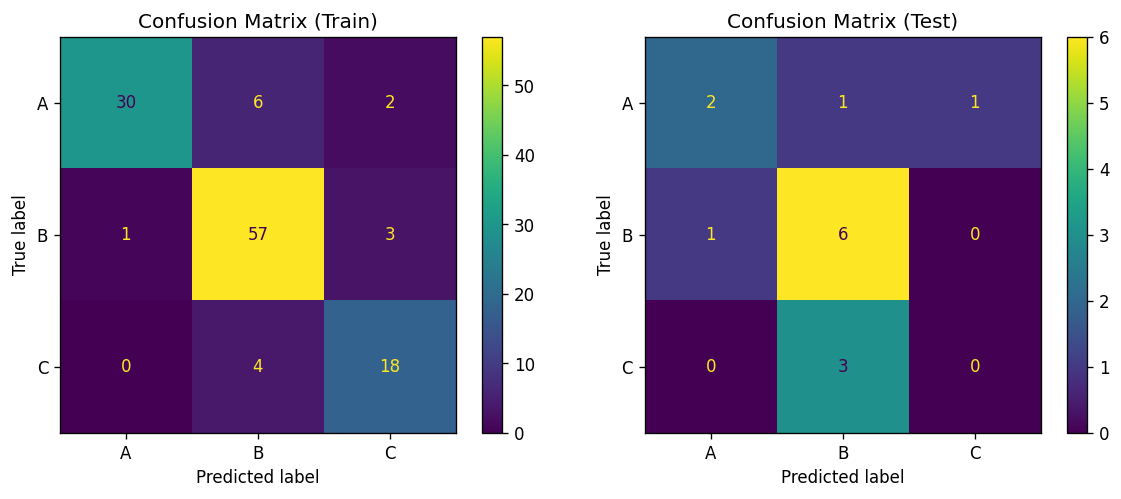

Train:
               precision    recall  f1-score   support

           A       0.97      0.79      0.87        38
           B       0.85      0.93      0.89        61
           C       0.78      0.82      0.80        22

    accuracy                           0.87       121
   macro avg       0.87      0.85      0.85       121
weighted avg       0.88      0.87      0.87       121

Test:
               precision    recall  f1-score   support

           A       0.67      0.50      0.57         4
           B       0.60      0.86      0.71         7
           C       0.00      0.00      0.00         3

    accuracy                           0.57        14
   macro avg       0.42      0.45      0.43        14
weighted avg       0.49      0.57      0.52        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,DecisionTreeClassifier,Train,0.95622,0.86777,0.87510,0.86777,0.86753
1,DecisionTreeClassifier,Test,0.67236,0.57143,0.49048,0.57143,0.51621


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Extra Trees Classifier

In [ ]:
%%time
model_name = 'ExtraTreesClassifier'

param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__criterion': ['gini'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', ExtraTreesClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 412 ms, sys: 15.7 ms, total: 427 ms
Wall time: 7.25 s


{'classifier__criterion': 'gini',
 'classifier__n_estimators': 100,
 'classifier__random_state': 54}

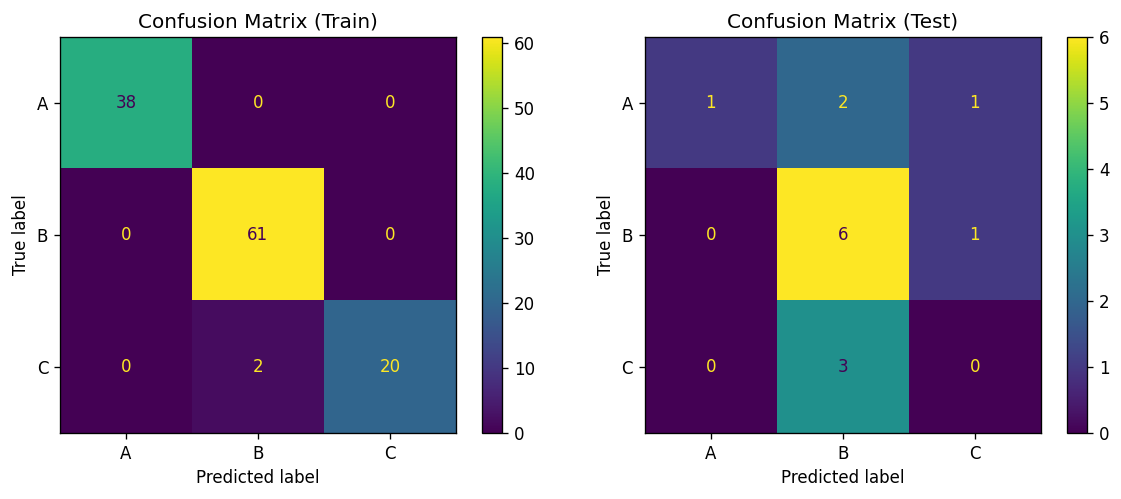

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        38
           B       0.97      1.00      0.98        61
           C       1.00      0.91      0.95        22

    accuracy                           0.98       121
   macro avg       0.99      0.97      0.98       121
weighted avg       0.98      0.98      0.98       121

Test:
               precision    recall  f1-score   support

           A       1.00      0.25      0.40         4
           B       0.55      0.86      0.67         7
           C       0.00      0.00      0.00         3

    accuracy                           0.50        14
   macro avg       0.52      0.37      0.36        14
weighted avg       0.56      0.50      0.45        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,ExtraTreesClassifier,Train,0.99956,0.98347,0.98400,0.98347,0.98321
1,ExtraTreesClassifier,Test,0.72189,0.50000,0.55844,0.50000,0.44762


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Random Forest Classifier

In [ ]:
%%time
model_name = 'RandomForestClassifier'

param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', RandomForestClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 844 ms, sys: 31 ms, total: 875 ms
Wall time: 28.7 s


{'classifier__criterion': 'entropy',
 'classifier__n_estimators': 200,
 'classifier__random_state': 54}

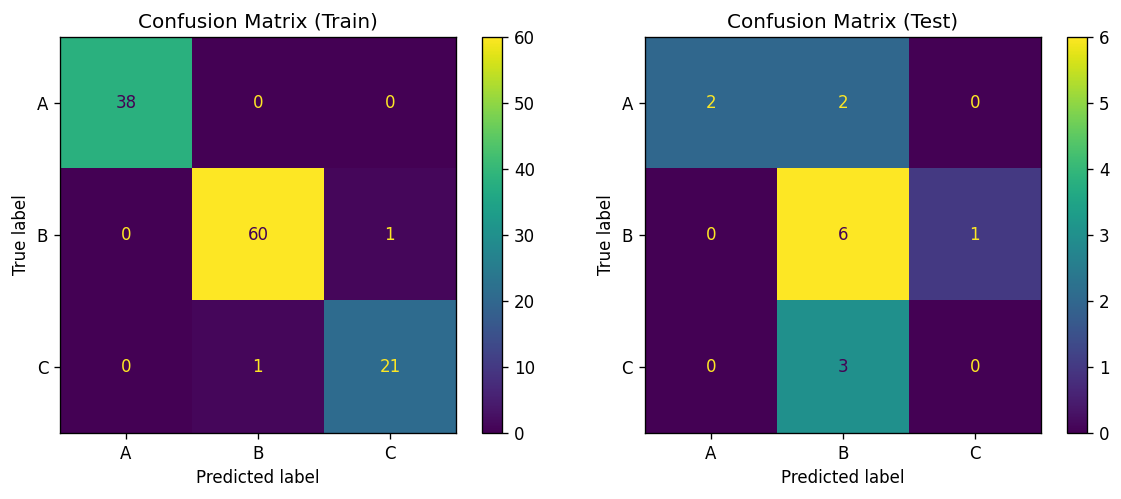

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        38
           B       0.98      0.98      0.98        61
           C       0.95      0.95      0.95        22

    accuracy                           0.98       121
   macro avg       0.98      0.98      0.98       121
weighted avg       0.98      0.98      0.98       121

Test:
               precision    recall  f1-score   support

           A       1.00      0.50      0.67         4
           B       0.55      0.86      0.67         7
           C       0.00      0.00      0.00         3

    accuracy                           0.57        14
   macro avg       0.52      0.45      0.44        14
weighted avg       0.56      0.57      0.52        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,RandomForestClassifier,Train,0.99956,0.98347,0.98347,0.98347,0.98347
1,RandomForestClassifier,Test,0.70696,0.57143,0.55844,0.57143,0.52381


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Gradient Boosting Classifier

In [ ]:
%%time
model_name = 'GradientBoostingClassifier'

param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200, 500],
    'classifier__max_depth': [None, 3, 10, 20],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', GradientBoostingClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_probs_train = model.predict_proba(X_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

model.best_params_

CPU times: user 4.79 s, sys: 50 ms, total: 4.84 s
Wall time: 1min 58s


{'classifier__max_depth': 3,
 'classifier__n_estimators': 500,
 'classifier__random_state': 54}

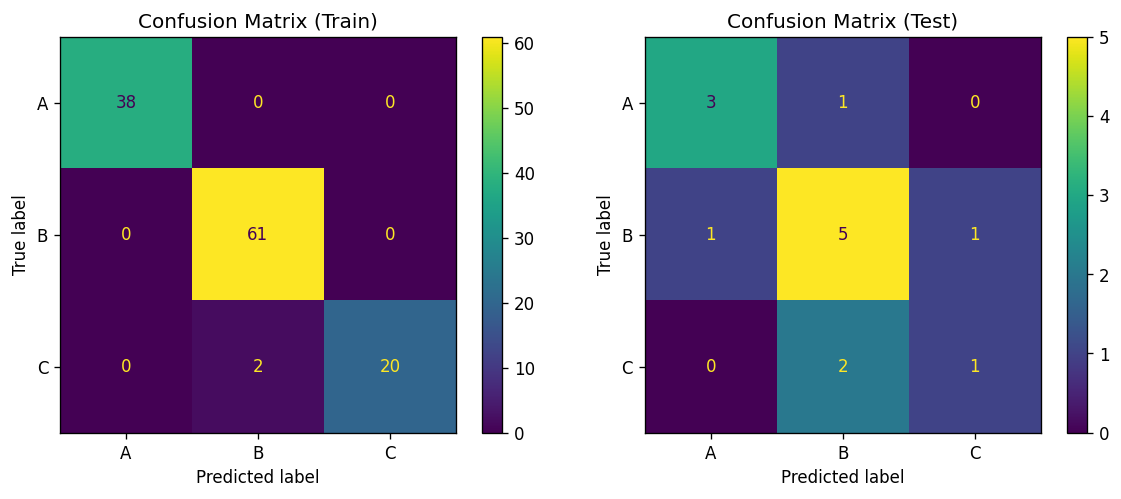

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        38
           B       0.97      1.00      0.98        61
           C       1.00      0.91      0.95        22

    accuracy                           0.98       121
   macro avg       0.99      0.97      0.98       121
weighted avg       0.98      0.98      0.98       121

Test:
               precision    recall  f1-score   support

           A       0.75      0.75      0.75         4
           B       0.62      0.71      0.67         7
           C       0.50      0.33      0.40         3

    accuracy                           0.64        14
   macro avg       0.62      0.60      0.61        14
weighted avg       0.63      0.64      0.63        14



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

cm_train = confusion_matrix(y_train, y_pred_train)
cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

cm_test = confusion_matrix(y_test, y_pred_test)
cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

cmp_train.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')

cmp_test.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f'/content/gdrive/My Drive/ESG/plots/{target}_model_{model_name}.png')
plt.show()

print('Train:\n', classification_report(y_train, y_pred_train))
print('Test:\n', classification_report(y_test, y_pred_test))

In [ ]:
result = pd.DataFrame(
    [
        [
            model_name,
            'Train',
            round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_train, y_pred_train), 5),
            round(precision_score(y_train, y_pred_train, average="weighted"), 5),
            round(recall_score(y_train, y_pred_train, average="weighted"), 5),
            round(f1_score(y_train, y_pred_train, average="weighted"), 5)
        ],
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)
result

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GradientBoostingClassifier,Train,0.99956,0.98347,0.98400,0.98347,0.98321
1,GradientBoostingClassifier,Test,0.71466,0.64286,0.63393,0.64286,0.63333


In [ ]:
result.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model_name}.xlsx', index=False)

#### Сводная результатов эксперимента

In [ ]:
models = [
    'GaussianNaiveBayes', 'KNeighborsClassifier', 'SupportVectorMachine', 'LogisticRegression',
    'DecisionTreeClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier'
]

results = pd.DataFrame()

for model in models:
    res = pd.read_excel(f'/content/gdrive/My Drive/ESG/results/{target}_model_{model}.xlsx')
    results = results.append(res)

results = results.reset_index(drop=True)
results.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_results.xlsx', index=False)
results

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GaussianNaiveBayes,Train,0.64631,0.38017,0.43663,0.38017,0.33181
1,GaussianNaiveBayes,Test,0.59879,0.35714,0.36667,0.35714,0.35238
2,KNeighborsClassifier,Train,0.99956,0.98347,0.98400,0.98347,0.98321
3,KNeighborsClassifier,Test,0.37486,0.21429,0.19048,0.21429,0.20000
4,SupportVectorMachine,Train,0.55792,0.50413,0.25415,0.50413,0.33793
5,SupportVectorMachine,Test,0.50380,0.50000,0.25000,0.50000,0.33333
6,LogisticRegression,Train,0.63576,0.50413,0.25415,0.50413,0.33793
7,LogisticRegression,Test,0.66827,0.50000,0.25000,0.50000,0.33333
8,DecisionTreeClassifier,Train,0.95622,0.86777,0.87510,0.86777,0.86753
9,DecisionTreeClassifier,Test,0.67236,0.57143,0.49048,0.57143,0.51621


#### Предсказание от лучшей модели

In [ ]:
%%time
model_name = 'GradientBoostingClassifier'

param_grid = {
    'classifier__n_estimators': [500],
    'classifier__max_depth': [3],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', GradientBoostingClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_probs_test = model.predict_proba(X_test)

CPU times: user 6.55 s, sys: 31.5 ms, total: 6.59 s
Wall time: 44.5 s


In [ ]:
final_res = features_data.loc[y_test.index][['company', target]]
final_res[f'Prediction({target})'] = y_pred_test
final_res[f'Probability({target})=A'] = y_pred_probs_test[:, 0]
final_res[f'Probability({target})=B'] = y_pred_probs_test[:, 1]
final_res[f'Probability({target})=C'] = y_pred_probs_test[:, 2]
final_res.reset_index(drop=True)

,company,G_Rating_band,Prediction(G_Rating_band),Probability(G_Rating_band)=A,Probability(G_Rating_band)=B,Probability(G_Rating_band)=C
0,ТАИФ-НК,C,B,1.234858e-04,0.999536,3.407221e-04
1,«Группа Компаний ПИК»,B,B,1.306468e-03,0.992350,6.344015e-03
2,Global Ports,B,C,1.594422e-06,0.060490,9.395080e-01
3,Globaltrans,A,A,8.914330e-01,0.003988,1.045790e-01
4,«Зарубежнефть»,B,B,5.047202e-04,0.999495,5.748234e-07
5,Россельхозбанк,B,B,2.105928e-04,0.999789,8.338740e-10
6,«КамАЗ»,C,B,8.130885e-09,0.999998,1.855809e-06
7,«АК БАРС» БАНК,A,A,9.999955e-01,0.000002,2.559919e-06
8,«Сахалин Энерджи»,B,B,1.887921e-04,0.999811,1.264584e-07
9,«Русвинил»,C,C,3.696614e-07,0.039784,9.602158e-01


In [ ]:
pd.DataFrame(
    [
        [
            model_name,
            'Test',
            round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
            round(accuracy_score(y_test, y_pred_test), 5),
            round(precision_score(y_test, y_pred_test, average="weighted"), 5),
            round(recall_score(y_test, y_pred_test, average="weighted"), 5),
            round(f1_score(y_test, y_pred_test, average="weighted"), 5)
        ]
    ],
    columns=['Model', 'Prediction Sample', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']
)

,Model,Prediction Sample,AUC-ROC,Accuracy,Precision,Recall,F1
0,GradientBoostingClassifier,Test,0.71466,0.64286,0.63393,0.64286,0.63333


In [ ]:
final_res.to_excel(f'/content/gdrive/My Drive/ESG/results/{target}_final_result.xlsx', index=False)

### Эксперимент №2.4: Вычисление ESG Rating band по компонентам E/S/G Rating band

In [139]:
X = features_data[features_data.index != 96].drop(columns=['ESG_Rank', 'ESG_Rating_band', 'E_Rank', 'E_Rating_band', 'S_Rank', 'S_Rating_band', 'G_Rank', 'G_Rating_band', 'company'])
y = features_data[features_data.index != 96][['ESG_Rating_band', 'E_Rating_band', 'S_Rating_band', 'G_Rating_band']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=54, shuffle=True, stratify=y)

y.value_counts()

ESG_Rating_band  E_Rating_band  S_Rating_band  G_Rating_band
B                B              B              B                34
C                C              C              C                23
                                               B                19
B                B              B              A                18
A                A              A              A                13
B                B              C              B                 7
                                               A                 6
C                C              B              B                 5
B                B              A              B                 3
A                A              B              A                 2
B                B              A              A                 2
C                C              B              C                 2
dtype: int64

In [140]:
%%time
target = 'ESG_Rating_band'

param_grid = {
    'classifier__n_estimators': [500],
    'classifier__criterion': ['gini'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', RandomForestClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train[target])

y_pred_test_esg = model.predict(X_test)
y_pred_probs_test_esg = model.predict_proba(X_test)

CPU times: user 1.09 s, sys: 63.6 ms, total: 1.16 s
Wall time: 8.51 s


In [141]:
%%time
target = 'E_Rating_band'

param_grid = {
    'classifier__n_estimators': [500],
    'classifier__criterion': ['gini'],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', RandomForestClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train[target])

y_pred_test_e = model.predict(X_test)
y_pred_probs_test_e = model.predict_proba(X_test)

CPU times: user 965 ms, sys: 5.27 ms, total: 971 ms
Wall time: 4.73 s


In [142]:
%%time
target = 'S_Rating_band'

param_grid = {
    'classifier__base_estimator__penalty': ['l2'],
    'classifier__base_estimator__C': [0.1],
    'classifier__base_estimator__max_iter': [100],
    'classifier__base_estimator__multi_class': ['ovr'],
    'classifier__base_estimator__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', CalibratedClassifierCV(LinearSVC()))
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train[target])

y_pred_test_s = model.predict(X_test)
y_pred_probs_test_s = model.predict_proba(X_test)

CPU times: user 105 ms, sys: 834 µs, total: 105 ms
Wall time: 430 ms


In [143]:
%%time
target = 'G_Rating_band'

param_grid = {
    'classifier__n_estimators': [500],
    'classifier__max_depth': [3],
    'classifier__random_state': [54],
}

custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', GradientBoostingClassifier())
])

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train[target])

y_pred_test_g = model.predict(X_test)
y_pred_probs_test_g = model.predict_proba(X_test)

CPU times: user 3.39 s, sys: 19.5 ms, total: 3.41 s
Wall time: 16 s


In [144]:
rating_brand_encoding = {'A': 3, 'B': 2, 'C': 1}

# final_res = features_data.loc[y_test.index][['company', 'ESG_Rating_band', 'E_Rating_band', 'S_Rating_band', 'G_Rating_band']]
final_res = features_data.loc[y_test.index][['company', 'ESG_Rating_band']]

final_res['Prediction(ESG_Rating_band)'] = y_pred_test_esg
# final_res['Probability(ESG_Rating_band)=A'] = y_pred_probs_test_esg[:, 0]
# final_res['Probability(ESG_Rating_band)=B'] = y_pred_probs_test_esg[:, 1]
# final_res['Probability(ESG_Rating_band)=C'] = y_pred_probs_test_esg[:, 2]

final_res['Prediction(E_Rating_band)'] = y_pred_test_e
# final_res['Probability(E_Rating_band)=A'] = y_pred_probs_test_e[:, 0]
# final_res['Probability(E_Rating_band)=B'] = y_pred_probs_test_e[:, 1]
# final_res['Probability(E_Rating_band)=C'] = y_pred_probs_test_e[:, 2]

final_res['Prediction(S_Rating_band)'] = y_pred_test_s
# final_res['Probability(S_Rating_band)=A'] = y_pred_probs_test_s[:, 0]
# final_res['Probability(S_Rating_band)=B'] = y_pred_probs_test_s[:, 1]
# final_res['Probability(S_Rating_band)=C'] = y_pred_probs_test_s[:, 2]

final_res['Prediction(G_Rating_band)'] = y_pred_test_g
# final_res['Probability(G_Rating_band)=A'] = y_pred_probs_test_g[:, 0]
# final_res['Probability(G_Rating_band)=B'] = y_pred_probs_test_g[:, 1]
# final_res['Probability(G_Rating_band)=C'] = y_pred_probs_test_g[:, 2]

final_res['Prediction(E_Rating_band)_encoded'] = final_res['Prediction(E_Rating_band)'].map(rating_brand_encoding)
final_res['Prediction(S_Rating_band)_encoded'] = final_res['Prediction(S_Rating_band)'].map(rating_brand_encoding)
final_res['Prediction(G_Rating_band)_encoded'] = final_res['Prediction(G_Rating_band)'].map(rating_brand_encoding)

final_res['Mean(Prediction(E/S/G_Rating_band))'] = ((final_res['Prediction(E_Rating_band)_encoded'] + final_res['Prediction(S_Rating_band)_encoded'] + final_res['Prediction(G_Rating_band)_encoded']) / 3).round()
final_res['Mean(Prediction(E/S/G_Rating_band))'] = final_res['Mean(Prediction(E/S/G_Rating_band))'].map({value: key for key, value in rating_brand_encoding.items()})

final_res.drop(columns=['Prediction(E_Rating_band)_encoded', 'Prediction(S_Rating_band)_encoded', 'Prediction(G_Rating_band)_encoded'], inplace=True)

final_res = final_res.sort_values(by='company').reset_index(drop=True)
final_res

,company,ESG_Rating_band,Prediction(ESG_Rating_band),Prediction(E_Rating_band),Prediction(S_Rating_band),Prediction(G_Rating_band),Mean(Prediction(E/S/G_Rating_band))
0,"""Титан"", группа компаний (деревообработка)",C,C,C,B,C,C
1,«АК БАРС» БАНК,B,B,B,B,A,B
2,"«Детский мир», группа компаний",B,B,B,B,A,B
3,«Зарубежнефть»,B,B,B,B,B,B
4,"«Илим», группа",B,B,B,B,A,B
5,«МОСКОВСКИЙ КРЕДИТНЫЙ БАНК»,A,C,C,B,B,B
6,«Первая грузовая компания»,B,B,B,B,B,B
7,«РусГидро»,B,C,C,B,B,B
8,«Русская медная компания»,C,C,C,C,B,C
9,"«Титан», группа компаний (нефтехимия)",C,C,C,B,C,C


In [145]:
final_res.to_excel('/content/gdrive/My Drive/ESG/results/final_result.xlsx', index=False)

In [146]:
final_res_scores = pd.DataFrame(
    [
        [
            'Prediction(ESG_Rating_band)',
            round(accuracy_score(final_res['ESG_Rating_band'], final_res['Prediction(ESG_Rating_band)']), 5),
            round(precision_score(final_res['ESG_Rating_band'], final_res['Prediction(ESG_Rating_band)'], average="weighted"), 5),
            round(recall_score(final_res['ESG_Rating_band'], final_res['Prediction(ESG_Rating_band)'], average="weighted"), 5),
            round(f1_score(final_res['ESG_Rating_band'], final_res['Prediction(ESG_Rating_band)'], average="weighted"), 5)
        ],
        [
            'Mean(Prediction(E/S/G_Rating_band))',
            round(accuracy_score(final_res['ESG_Rating_band'], final_res['Mean(Prediction(E/S/G_Rating_band))']), 5),
            round(precision_score(final_res['ESG_Rating_band'], final_res['Mean(Prediction(E/S/G_Rating_band))'], average="weighted"), 5),
            round(recall_score(final_res['ESG_Rating_band'], final_res['Mean(Prediction(E/S/G_Rating_band))'], average="weighted"), 5),
            round(f1_score(final_res['ESG_Rating_band'], final_res['Mean(Prediction(E/S/G_Rating_band))'], average="weighted"), 5)
        ]
    ],
    columns=['Experiment', 'Accuracy', 'Precision', 'Recall', 'F1']
)
final_res_scores

,Experiment,Accuracy,Precision,Recall,F1
0,Prediction(ESG_Rating_band),0.71429,0.66147,0.71429,0.67979
1,Mean(Prediction(E/S/G_Rating_band)),0.76190,0.70068,0.76190,0.72381


In [147]:
final_res_scores.to_excel('/content/gdrive/My Drive/ESG/results/final_res_scores.xlsx', index=False)